In [2]:
import pandas as pd
import numpy as np
import os

import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

In [3]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

In [4]:
from data_process import data_preparation

def select_data(config):
    #data = pd.DataFrame()
    #data preparation
    if(not config.flags['data_preprocessing']['work']):
        if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
            data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
        else:
            data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    
    return data

In [5]:
data = select_data(config)

data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,239.177460,27.055966,0.090353,0.000027,0.086462,0.171325,0.000000,1.000000,0.000000,12,...,2.357481,0.340302,0.687168,0.787404,0,0,0,0,1,0
1,169.268150,4.427474,1.170077,0.000150,0.032336,0.068488,1.000000,0.000000,0.000000,12,...,0.837587,0.263093,0.681880,0.827843,1,0,0,0,0,0
2,43.250305,-3.342976,0.244153,0.000030,0.200110,0.594563,0.000336,0.013068,0.984260,13,...,1.140024,0.338401,0.654243,0.815071,0,0,0,0,1,0
3,172.780700,45.426833,1.229971,0.000552,0.045566,0.092679,0.999922,0.000000,0.000078,12,...,1.358093,0.379193,0.672553,0.808466,1,0,0,0,0,0
4,150.185940,2.474568,0.000868,0.000008,0.124031,0.150412,0.000000,0.000000,0.999934,12,...,0.739153,0.254910,0.702885,0.882802,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090354,219.531190,15.218142,0.098927,0.000009,0.011590,0.030389,0.000000,1.000000,0.000000,13,...,2.128290,0.438617,0.677479,0.554826,0,0,0,1,0,0
1090355,9.150885,23.917155,2.520883,0.000440,0.045041,0.395291,1.000000,0.000000,0.000000,13,...,3.519597,0.078064,0.642015,0.640678,1,0,0,0,0,0
1090356,33.514822,6.673856,-0.000333,0.000012,0.065429,0.236262,0.000000,0.000000,0.999985,13,...,3.740190,0.071538,0.565084,0.879244,0,0,0,0,0,1
1090357,3.715578,4.087570,1.855977,0.000165,0.068224,0.877788,1.000000,0.000000,0.000000,13,...,1.609952,0.407870,0.639610,0.800421,1,0,0,0,0,0


In [6]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
from network import LoadModel,make_custom_index

name = f"custom_sm_{make_custom_index('00',config.hyperparam['model_variable']['neuron_count'])}"

model = LoadModel(f'{config.path_model}_{name}',f'{config.path_weight}_{name}',config.hyperparam['optimizer'],config.hyperparam['loss'])

2024-05-10 15:51:05.324206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model is loaded from disk



['var', 'color']
50/50 [==============================] - 0s 373us/step


Permutation explainer:   0%|          | 8/2000 [00:00<?, ?it/s]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   0%|          | 10/2000 [00:12<22:45,  1.46it/s]

50/50 [==============================] - 0s 417us/step


Permutation explainer:   1%|          | 11/2000 [00:13<31:57,  1.04it/s]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   1%|          | 12/2000 [00:15<37:02,  1.12s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:   1%|          | 13/2000 [00:16<39:47,  1.20s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   1%|          | 14/2000 [00:17<41:35,  1.26s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:   1%|          | 15/2000 [00:19<42:44,  1.29s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:   1%|          | 16/2000 [00:20<43:18,  1.31s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   1%|          | 17/2000 [00:21<43:53,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   1%|          | 18/2000 [00:23<43:49,  1.33s/it]

50/50 [==============================] - 0s 327us/step


Permutation explainer:   1%|          | 19/2000 [00:24<43:52,  1.33s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:   1%|          | 20/2000 [00:25<43:53,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   1%|          | 21/2000 [00:27<43:54,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   1%|          | 22/2000 [00:28<43:43,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:   1%|          | 23/2000 [00:29<43:53,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   1%|          | 24/2000 [00:31<43:46,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:   1%|▏         | 25/2000 [00:32<43:36,  1.32s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   1%|▏         | 26/2000 [00:33<43:28,  1.32s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:   1%|▏         | 27/2000 [00:35<43:14,  1.32s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:   1%|▏         | 28/2000 [00:36<43:14,  1.32s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:   1%|▏         | 29/2000 [00:37<43:13,  1.32s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   2%|▏         | 30/2000 [00:39<43:12,  1.32s/it]

50/50 [==============================] - 0s 414us/step


Permutation explainer:   2%|▏         | 31/2000 [00:40<43:09,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   2%|▏         | 32/2000 [00:41<43:00,  1.31s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:   2%|▏         | 33/2000 [00:42<43:00,  1.31s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:   2%|▏         | 34/2000 [00:44<43:07,  1.32s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:   2%|▏         | 35/2000 [00:45<43:12,  1.32s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:   2%|▏         | 36/2000 [00:46<43:04,  1.32s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:   2%|▏         | 37/2000 [00:48<43:03,  1.32s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   2%|▏         | 38/2000 [00:49<42:56,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   2%|▏         | 39/2000 [00:50<42:55,  1.31s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:   2%|▏         | 40/2000 [00:52<42:58,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   2%|▏         | 41/2000 [00:53<42:45,  1.31s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:   2%|▏         | 42/2000 [00:54<42:40,  1.31s/it]

50/50 [==============================] - 0s 346us/step


Permutation explainer:   2%|▏         | 43/2000 [00:56<42:36,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   2%|▏         | 44/2000 [00:57<42:27,  1.30s/it]

50/50 [==============================] - 0s 394us/step


Permutation explainer:   2%|▏         | 45/2000 [00:58<42:30,  1.30s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:   2%|▏         | 46/2000 [01:00<42:41,  1.31s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   2%|▏         | 47/2000 [01:01<42:35,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   2%|▏         | 48/2000 [01:02<44:48,  1.38s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:   2%|▏         | 49/2000 [01:04<44:50,  1.38s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:   2%|▎         | 50/2000 [01:05<44:51,  1.38s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   3%|▎         | 51/2000 [01:06<44:45,  1.38s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   3%|▎         | 52/2000 [01:08<44:18,  1.36s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:   3%|▎         | 53/2000 [01:09<43:54,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   3%|▎         | 54/2000 [01:10<43:33,  1.34s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:   3%|▎         | 55/2000 [01:12<43:10,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   3%|▎         | 56/2000 [01:13<42:53,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   3%|▎         | 57/2000 [01:14<42:49,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   3%|▎         | 58/2000 [01:16<42:39,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:   3%|▎         | 59/2000 [01:17<42:39,  1.32s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:   3%|▎         | 60/2000 [01:18<42:37,  1.32s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   3%|▎         | 61/2000 [01:20<42:32,  1.32s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:   3%|▎         | 62/2000 [01:21<42:28,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   3%|▎         | 63/2000 [01:22<42:28,  1.32s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:   3%|▎         | 64/2000 [01:24<42:19,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   3%|▎         | 65/2000 [01:25<42:22,  1.31s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   3%|▎         | 66/2000 [01:26<42:12,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   3%|▎         | 67/2000 [01:28<42:07,  1.31s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   3%|▎         | 68/2000 [01:29<42:14,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   3%|▎         | 69/2000 [01:30<42:10,  1.31s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:   4%|▎         | 70/2000 [01:31<42:09,  1.31s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:   4%|▎         | 71/2000 [01:33<42:08,  1.31s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:   4%|▎         | 72/2000 [01:34<42:10,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   4%|▎         | 73/2000 [01:35<42:06,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   4%|▎         | 74/2000 [01:37<42:06,  1.31s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   4%|▍         | 75/2000 [01:38<42:04,  1.31s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:   4%|▍         | 76/2000 [01:39<41:56,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   4%|▍         | 77/2000 [01:41<41:54,  1.31s/it]

50/50 [==============================] - 0s 346us/step


Permutation explainer:   4%|▍         | 78/2000 [01:42<41:57,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   4%|▍         | 79/2000 [01:43<41:55,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   4%|▍         | 80/2000 [01:45<41:48,  1.31s/it]

50/50 [==============================] - 0s 390us/step


Permutation explainer:   4%|▍         | 81/2000 [01:46<41:45,  1.31s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:   4%|▍         | 82/2000 [01:47<41:37,  1.30s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:   4%|▍         | 83/2000 [01:48<41:40,  1.30s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:   4%|▍         | 84/2000 [01:50<41:58,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:   4%|▍         | 85/2000 [01:51<41:50,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   4%|▍         | 86/2000 [01:52<41:46,  1.31s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:   4%|▍         | 87/2000 [01:54<41:47,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   4%|▍         | 88/2000 [01:55<41:41,  1.31s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:   4%|▍         | 89/2000 [01:56<41:43,  1.31s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   4%|▍         | 90/2000 [01:58<41:41,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   5%|▍         | 91/2000 [01:59<41:51,  1.32s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   5%|▍         | 92/2000 [02:00<41:45,  1.31s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:   5%|▍         | 93/2000 [02:02<41:37,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   5%|▍         | 94/2000 [02:03<41:36,  1.31s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:   5%|▍         | 95/2000 [02:04<41:39,  1.31s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:   5%|▍         | 96/2000 [02:06<41:38,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   5%|▍         | 97/2000 [02:07<41:40,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:   5%|▍         | 98/2000 [02:08<41:35,  1.31s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:   5%|▍         | 99/2000 [02:09<41:29,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   5%|▌         | 100/2000 [02:11<41:34,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   5%|▌         | 101/2000 [02:12<41:28,  1.31s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:   5%|▌         | 102/2000 [02:13<41:27,  1.31s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:   5%|▌         | 103/2000 [02:15<41:30,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:   5%|▌         | 104/2000 [02:16<41:29,  1.31s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   5%|▌         | 105/2000 [02:17<41:37,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   5%|▌         | 106/2000 [02:19<41:32,  1.32s/it]

50/50 [==============================] - 0s 435us/step


Permutation explainer:   5%|▌         | 107/2000 [02:20<41:31,  1.32s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:   5%|▌         | 108/2000 [02:21<41:30,  1.32s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   5%|▌         | 109/2000 [02:23<41:25,  1.31s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   6%|▌         | 110/2000 [02:24<41:25,  1.31s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:   6%|▌         | 111/2000 [02:25<41:27,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:   6%|▌         | 112/2000 [02:27<41:20,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   6%|▌         | 113/2000 [02:28<43:40,  1.39s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   6%|▌         | 114/2000 [02:29<43:32,  1.39s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   6%|▌         | 115/2000 [02:31<43:24,  1.38s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   6%|▌         | 116/2000 [02:32<43:14,  1.38s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   6%|▌         | 117/2000 [02:34<42:52,  1.37s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:   6%|▌         | 118/2000 [02:35<42:28,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   6%|▌         | 119/2000 [02:36<42:10,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   6%|▌         | 120/2000 [02:38<41:50,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:   6%|▌         | 121/2000 [02:39<41:41,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:   6%|▌         | 122/2000 [02:40<41:37,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   6%|▌         | 123/2000 [02:41<41:26,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   6%|▌         | 124/2000 [02:43<41:14,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   6%|▋         | 125/2000 [02:44<41:02,  1.31s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   6%|▋         | 126/2000 [02:45<40:57,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   6%|▋         | 127/2000 [02:47<41:06,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   6%|▋         | 128/2000 [02:48<40:52,  1.31s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   6%|▋         | 129/2000 [02:49<40:53,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   6%|▋         | 130/2000 [02:51<40:54,  1.31s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   7%|▋         | 131/2000 [02:52<40:52,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:   7%|▋         | 132/2000 [02:53<40:57,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   7%|▋         | 133/2000 [02:55<40:54,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:   7%|▋         | 134/2000 [02:56<40:53,  1.31s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:   7%|▋         | 135/2000 [02:57<41:04,  1.32s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:   7%|▋         | 136/2000 [02:59<40:59,  1.32s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:   7%|▋         | 137/2000 [03:00<40:53,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   7%|▋         | 138/2000 [03:01<40:51,  1.32s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:   7%|▋         | 139/2000 [03:02<40:45,  1.31s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:   7%|▋         | 140/2000 [03:04<40:52,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   7%|▋         | 141/2000 [03:05<40:47,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   7%|▋         | 142/2000 [03:06<40:40,  1.31s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:   7%|▋         | 143/2000 [03:08<40:42,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   7%|▋         | 144/2000 [03:09<40:37,  1.31s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:   7%|▋         | 145/2000 [03:10<40:34,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   7%|▋         | 146/2000 [03:12<40:37,  1.31s/it]

50/50 [==============================] - 0s 395us/step


Permutation explainer:   7%|▋         | 147/2000 [03:13<40:34,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   7%|▋         | 148/2000 [03:14<40:46,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:   7%|▋         | 149/2000 [03:16<40:49,  1.32s/it]

50/50 [==============================] - 0s 337us/step


Permutation explainer:   8%|▊         | 150/2000 [03:17<40:35,  1.32s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   8%|▊         | 151/2000 [03:18<40:26,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   8%|▊         | 152/2000 [03:20<40:36,  1.32s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   8%|▊         | 153/2000 [03:21<40:30,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   8%|▊         | 154/2000 [03:22<40:35,  1.32s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:   8%|▊         | 155/2000 [03:24<40:30,  1.32s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:   8%|▊         | 156/2000 [03:25<40:27,  1.32s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:   8%|▊         | 157/2000 [03:26<40:29,  1.32s/it]

50/50 [==============================] - 0s 324us/step


Permutation explainer:   8%|▊         | 158/2000 [03:27<40:15,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   8%|▊         | 159/2000 [03:29<40:15,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:   8%|▊         | 160/2000 [03:30<40:23,  1.32s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   8%|▊         | 161/2000 [03:31<40:15,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:   8%|▊         | 162/2000 [03:33<40:26,  1.32s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   8%|▊         | 163/2000 [03:34<40:25,  1.32s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:   8%|▊         | 164/2000 [03:35<40:21,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:   8%|▊         | 165/2000 [03:37<40:21,  1.32s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   8%|▊         | 166/2000 [03:38<40:11,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:   8%|▊         | 167/2000 [03:39<40:03,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:   8%|▊         | 168/2000 [03:41<40:05,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   8%|▊         | 169/2000 [03:42<40:01,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:   8%|▊         | 170/2000 [03:43<39:59,  1.31s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:   9%|▊         | 171/2000 [03:45<39:55,  1.31s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:   9%|▊         | 172/2000 [03:46<39:58,  1.31s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:   9%|▊         | 173/2000 [03:47<40:07,  1.32s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:   9%|▊         | 174/2000 [03:49<40:00,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   9%|▉         | 175/2000 [03:50<40:05,  1.32s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   9%|▉         | 176/2000 [03:51<40:04,  1.32s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   9%|▉         | 177/2000 [03:53<40:02,  1.32s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   9%|▉         | 178/2000 [03:54<42:16,  1.39s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   9%|▉         | 179/2000 [03:55<42:05,  1.39s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:   9%|▉         | 180/2000 [03:57<42:05,  1.39s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:   9%|▉         | 181/2000 [03:58<41:59,  1.39s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:   9%|▉         | 182/2000 [04:00<41:43,  1.38s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:   9%|▉         | 183/2000 [04:01<41:19,  1.36s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:   9%|▉         | 184/2000 [04:02<40:53,  1.35s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:   9%|▉         | 185/2000 [04:04<40:37,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:   9%|▉         | 186/2000 [04:05<40:21,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:   9%|▉         | 187/2000 [04:06<40:09,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:   9%|▉         | 188/2000 [04:07<39:59,  1.32s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:   9%|▉         | 189/2000 [04:09<40:01,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  10%|▉         | 190/2000 [04:10<39:56,  1.32s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  10%|▉         | 191/2000 [04:11<39:47,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  10%|▉         | 192/2000 [04:13<39:43,  1.32s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  10%|▉         | 193/2000 [04:14<39:33,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  10%|▉         | 194/2000 [04:15<39:36,  1.32s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  10%|▉         | 195/2000 [04:17<39:40,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  10%|▉         | 196/2000 [04:18<39:46,  1.32s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  10%|▉         | 197/2000 [04:19<39:32,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  10%|▉         | 198/2000 [04:21<39:28,  1.31s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  10%|▉         | 199/2000 [04:22<39:38,  1.32s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  10%|█         | 200/2000 [04:23<39:28,  1.32s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  10%|█         | 201/2000 [04:25<39:26,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  10%|█         | 202/2000 [04:26<39:29,  1.32s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  10%|█         | 203/2000 [04:27<39:25,  1.32s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  10%|█         | 204/2000 [04:29<39:24,  1.32s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  10%|█         | 205/2000 [04:30<39:14,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  10%|█         | 206/2000 [04:31<39:11,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  10%|█         | 207/2000 [04:32<39:16,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  10%|█         | 208/2000 [04:34<39:11,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  10%|█         | 209/2000 [04:35<39:12,  1.31s/it]

50/50 [==============================] - 0s 385us/step


Permutation explainer:  10%|█         | 210/2000 [04:36<39:11,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  11%|█         | 211/2000 [04:38<39:08,  1.31s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  11%|█         | 212/2000 [04:39<39:07,  1.31s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  11%|█         | 213/2000 [04:40<39:00,  1.31s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  11%|█         | 214/2000 [04:42<39:04,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  11%|█         | 215/2000 [04:43<39:01,  1.31s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  11%|█         | 216/2000 [04:44<38:59,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  11%|█         | 217/2000 [04:46<38:56,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  11%|█         | 218/2000 [04:47<38:59,  1.31s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  11%|█         | 219/2000 [04:48<38:57,  1.31s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  11%|█         | 220/2000 [04:50<38:59,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  11%|█         | 221/2000 [04:51<38:59,  1.31s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  11%|█         | 222/2000 [04:52<38:55,  1.31s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  11%|█         | 223/2000 [04:54<38:55,  1.31s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  11%|█         | 224/2000 [04:55<38:54,  1.31s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  11%|█▏        | 225/2000 [04:56<38:50,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  11%|█▏        | 226/2000 [04:57<38:48,  1.31s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:  11%|█▏        | 227/2000 [04:59<38:40,  1.31s/it]

50/50 [==============================] - 0s 410us/step


Permutation explainer:  11%|█▏        | 228/2000 [05:00<38:42,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  11%|█▏        | 229/2000 [05:01<38:40,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  12%|█▏        | 230/2000 [05:03<38:43,  1.31s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  12%|█▏        | 231/2000 [05:04<38:45,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  12%|█▏        | 232/2000 [05:05<38:37,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  12%|█▏        | 233/2000 [05:07<38:43,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  12%|█▏        | 234/2000 [05:08<38:40,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  12%|█▏        | 235/2000 [05:09<38:34,  1.31s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  12%|█▏        | 236/2000 [05:11<38:27,  1.31s/it]

50/50 [==============================] - 0s 412us/step


Permutation explainer:  12%|█▏        | 237/2000 [05:12<38:29,  1.31s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  12%|█▏        | 238/2000 [05:13<38:33,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  12%|█▏        | 239/2000 [05:14<38:27,  1.31s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  12%|█▏        | 240/2000 [05:16<38:31,  1.31s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  12%|█▏        | 241/2000 [05:17<38:28,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  12%|█▏        | 242/2000 [05:18<38:26,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  12%|█▏        | 243/2000 [05:20<40:38,  1.39s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  12%|█▏        | 244/2000 [05:21<40:30,  1.38s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  12%|█▏        | 245/2000 [05:23<40:24,  1.38s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  12%|█▏        | 246/2000 [05:24<40:21,  1.38s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  12%|█▏        | 247/2000 [05:25<40:12,  1.38s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  12%|█▏        | 248/2000 [05:27<39:56,  1.37s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  12%|█▏        | 249/2000 [05:28<39:37,  1.36s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  12%|█▎        | 250/2000 [05:29<39:16,  1.35s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:  13%|█▎        | 251/2000 [05:31<38:53,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  13%|█▎        | 252/2000 [05:32<39:07,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  13%|█▎        | 253/2000 [05:34<39:09,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  13%|█▎        | 254/2000 [05:35<39:13,  1.35s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  13%|█▎        | 255/2000 [05:36<39:11,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  13%|█▎        | 256/2000 [05:38<39:15,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  13%|█▎        | 257/2000 [05:39<39:17,  1.35s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  13%|█▎        | 258/2000 [05:40<39:21,  1.36s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  13%|█▎        | 259/2000 [05:42<39:11,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  13%|█▎        | 260/2000 [05:43<38:55,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  13%|█▎        | 261/2000 [05:44<38:50,  1.34s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:  13%|█▎        | 262/2000 [05:46<38:40,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  13%|█▎        | 263/2000 [05:47<38:35,  1.33s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:  13%|█▎        | 264/2000 [05:48<38:46,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  13%|█▎        | 265/2000 [05:50<38:57,  1.35s/it]

50/50 [==============================] - 0s 333us/step


Permutation explainer:  13%|█▎        | 266/2000 [05:51<38:50,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  13%|█▎        | 267/2000 [05:52<38:42,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  13%|█▎        | 268/2000 [05:54<38:37,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  13%|█▎        | 269/2000 [05:55<38:35,  1.34s/it]

50/50 [==============================] - 0s 387us/step


Permutation explainer:  14%|█▎        | 270/2000 [05:56<38:38,  1.34s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  14%|█▎        | 271/2000 [05:58<38:38,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  14%|█▎        | 272/2000 [05:59<38:40,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  14%|█▎        | 273/2000 [06:00<38:33,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  14%|█▎        | 274/2000 [06:02<38:35,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  14%|█▍        | 275/2000 [06:03<38:33,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  14%|█▍        | 276/2000 [06:04<38:32,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  14%|█▍        | 277/2000 [06:06<38:26,  1.34s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:  14%|█▍        | 278/2000 [06:07<38:16,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  14%|█▍        | 279/2000 [06:08<38:18,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  14%|█▍        | 280/2000 [06:10<38:14,  1.33s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:  14%|█▍        | 281/2000 [06:11<38:14,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  14%|█▍        | 282/2000 [06:12<38:03,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  14%|█▍        | 283/2000 [06:14<38:01,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  14%|█▍        | 284/2000 [06:15<38:03,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  14%|█▍        | 285/2000 [06:16<37:59,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  14%|█▍        | 286/2000 [06:18<38:01,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  14%|█▍        | 287/2000 [06:19<38:05,  1.33s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  14%|█▍        | 288/2000 [06:20<38:14,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  14%|█▍        | 289/2000 [06:22<37:56,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  14%|█▍        | 290/2000 [06:23<37:56,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  15%|█▍        | 291/2000 [06:24<38:00,  1.33s/it]

50/50 [==============================] - 0s 395us/step


Permutation explainer:  15%|█▍        | 292/2000 [06:26<38:02,  1.34s/it]

50/50 [==============================] - 0s 471us/step


Permutation explainer:  15%|█▍        | 293/2000 [06:27<37:51,  1.33s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  15%|█▍        | 294/2000 [06:28<37:43,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  15%|█▍        | 295/2000 [06:30<37:35,  1.32s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  15%|█▍        | 296/2000 [06:31<37:32,  1.32s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  15%|█▍        | 297/2000 [06:32<37:30,  1.32s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  15%|█▍        | 298/2000 [06:34<37:29,  1.32s/it]

50/50 [==============================] - 0s 348us/step


Permutation explainer:  15%|█▍        | 299/2000 [06:35<37:16,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  15%|█▌        | 300/2000 [06:36<37:12,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  15%|█▌        | 301/2000 [06:38<37:11,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  15%|█▌        | 302/2000 [06:39<37:10,  1.31s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  15%|█▌        | 303/2000 [06:40<37:19,  1.32s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  15%|█▌        | 304/2000 [06:42<37:25,  1.32s/it]

50/50 [==============================] - 0s 344us/step


Permutation explainer:  15%|█▌        | 305/2000 [06:43<37:29,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  15%|█▌        | 306/2000 [06:44<37:33,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  15%|█▌        | 307/2000 [06:46<37:28,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  15%|█▌        | 308/2000 [06:47<37:26,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  15%|█▌        | 309/2000 [06:48<40:02,  1.42s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  16%|█▌        | 310/2000 [06:50<40:02,  1.42s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  16%|█▌        | 311/2000 [06:51<40:26,  1.44s/it]

50/50 [==============================] - 0s 404us/step


Permutation explainer:  16%|█▌        | 312/2000 [06:53<40:35,  1.44s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  16%|█▌        | 313/2000 [06:54<40:07,  1.43s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  16%|█▌        | 314/2000 [06:56<39:23,  1.40s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  16%|█▌        | 315/2000 [06:57<38:43,  1.38s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  16%|█▌        | 316/2000 [06:58<38:14,  1.36s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  16%|█▌        | 317/2000 [07:00<38:02,  1.36s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  16%|█▌        | 318/2000 [07:01<37:37,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  16%|█▌        | 319/2000 [07:02<37:14,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  16%|█▌        | 320/2000 [07:03<36:59,  1.32s/it]

50/50 [==============================] - 0s 388us/step


Permutation explainer:  16%|█▌        | 321/2000 [07:05<37:03,  1.32s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  16%|█▌        | 322/2000 [07:06<37:07,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  16%|█▌        | 323/2000 [07:07<37:05,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  16%|█▌        | 324/2000 [07:09<36:58,  1.32s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  16%|█▋        | 325/2000 [07:10<36:53,  1.32s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  16%|█▋        | 326/2000 [07:11<36:50,  1.32s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  16%|█▋        | 327/2000 [07:13<36:53,  1.32s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  16%|█▋        | 328/2000 [07:14<36:48,  1.32s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  16%|█▋        | 329/2000 [07:15<36:51,  1.32s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  16%|█▋        | 330/2000 [07:17<36:44,  1.32s/it]

50/50 [==============================] - 0s 451us/step


Permutation explainer:  17%|█▋        | 331/2000 [07:18<36:48,  1.32s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  17%|█▋        | 332/2000 [07:19<36:49,  1.32s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  17%|█▋        | 333/2000 [07:21<36:48,  1.32s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  17%|█▋        | 334/2000 [07:22<36:43,  1.32s/it]

50/50 [==============================] - 0s 346us/step


Permutation explainer:  17%|█▋        | 335/2000 [07:23<36:33,  1.32s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  17%|█▋        | 336/2000 [07:25<36:23,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  17%|█▋        | 337/2000 [07:26<36:20,  1.31s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  17%|█▋        | 338/2000 [07:27<36:20,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  17%|█▋        | 339/2000 [07:29<36:16,  1.31s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:  17%|█▋        | 340/2000 [07:30<36:18,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  17%|█▋        | 341/2000 [07:31<36:13,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  17%|█▋        | 342/2000 [07:32<36:06,  1.31s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  17%|█▋        | 343/2000 [07:34<36:15,  1.31s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  17%|█▋        | 344/2000 [07:35<36:13,  1.31s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  17%|█▋        | 345/2000 [07:36<36:11,  1.31s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  17%|█▋        | 346/2000 [07:38<36:12,  1.31s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  17%|█▋        | 347/2000 [07:39<36:11,  1.31s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  17%|█▋        | 348/2000 [07:40<36:09,  1.31s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  17%|█▋        | 349/2000 [07:42<36:14,  1.32s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  18%|█▊        | 350/2000 [07:43<36:06,  1.31s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  18%|█▊        | 351/2000 [07:44<36:04,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  18%|█▊        | 352/2000 [07:46<36:03,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  18%|█▊        | 353/2000 [07:47<35:56,  1.31s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  18%|█▊        | 354/2000 [07:48<35:51,  1.31s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:  18%|█▊        | 355/2000 [07:50<35:55,  1.31s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  18%|█▊        | 356/2000 [07:51<35:52,  1.31s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  18%|█▊        | 357/2000 [07:52<35:57,  1.31s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  18%|█▊        | 358/2000 [07:53<35:51,  1.31s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:  18%|█▊        | 359/2000 [07:55<35:47,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  18%|█▊        | 360/2000 [07:56<35:53,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  18%|█▊        | 361/2000 [07:57<35:54,  1.31s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  18%|█▊        | 362/2000 [07:59<35:50,  1.31s/it]

50/50 [==============================] - 0s 325us/step


Permutation explainer:  18%|█▊        | 363/2000 [08:00<35:45,  1.31s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  18%|█▊        | 364/2000 [08:01<35:44,  1.31s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  18%|█▊        | 365/2000 [08:03<35:39,  1.31s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  18%|█▊        | 366/2000 [08:04<35:38,  1.31s/it]

50/50 [==============================] - 0s 443us/step


Permutation explainer:  18%|█▊        | 367/2000 [08:05<35:41,  1.31s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  18%|█▊        | 368/2000 [08:07<35:48,  1.32s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  18%|█▊        | 369/2000 [08:08<35:58,  1.32s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  18%|█▊        | 370/2000 [08:09<35:59,  1.32s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  19%|█▊        | 371/2000 [08:11<36:06,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  19%|█▊        | 372/2000 [08:12<36:07,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  19%|█▊        | 373/2000 [08:13<36:17,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  19%|█▊        | 374/2000 [08:15<38:28,  1.42s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  19%|█▉        | 375/2000 [08:16<38:37,  1.43s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  19%|█▉        | 376/2000 [08:18<38:39,  1.43s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  19%|█▉        | 377/2000 [08:19<38:23,  1.42s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  19%|█▉        | 378/2000 [08:21<37:53,  1.40s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  19%|█▉        | 379/2000 [08:22<37:31,  1.39s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  19%|█▉        | 380/2000 [08:23<37:13,  1.38s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  19%|█▉        | 381/2000 [08:25<36:49,  1.36s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  19%|█▉        | 382/2000 [08:26<36:32,  1.36s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  19%|█▉        | 383/2000 [08:27<36:22,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  19%|█▉        | 384/2000 [08:29<36:11,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  19%|█▉        | 385/2000 [08:30<36:02,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  19%|█▉        | 386/2000 [08:31<36:08,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  19%|█▉        | 387/2000 [08:33<36:06,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  19%|█▉        | 388/2000 [08:34<36:13,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  19%|█▉        | 389/2000 [08:35<35:57,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  20%|█▉        | 390/2000 [08:37<35:53,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  20%|█▉        | 391/2000 [08:38<35:46,  1.33s/it]

50/50 [==============================] - 0s 327us/step


Permutation explainer:  20%|█▉        | 392/2000 [08:39<35:32,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  20%|█▉        | 393/2000 [08:41<35:41,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  20%|█▉        | 394/2000 [08:42<35:40,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  20%|█▉        | 395/2000 [08:43<35:34,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  20%|█▉        | 396/2000 [08:45<35:36,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  20%|█▉        | 397/2000 [08:46<35:40,  1.34s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  20%|█▉        | 398/2000 [08:47<35:36,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  20%|█▉        | 399/2000 [08:49<35:40,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  20%|██        | 400/2000 [08:50<35:37,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  20%|██        | 401/2000 [08:51<35:32,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  20%|██        | 402/2000 [08:53<35:27,  1.33s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  20%|██        | 403/2000 [08:54<35:27,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  20%|██        | 404/2000 [08:55<35:33,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  20%|██        | 405/2000 [08:57<35:30,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  20%|██        | 406/2000 [08:58<35:21,  1.33s/it]

50/50 [==============================] - 0s 330us/step


Permutation explainer:  20%|██        | 407/2000 [08:59<35:19,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  20%|██        | 408/2000 [09:01<35:18,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  20%|██        | 409/2000 [09:02<35:26,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  20%|██        | 410/2000 [09:03<35:21,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  21%|██        | 411/2000 [09:05<35:20,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  21%|██        | 412/2000 [09:06<35:14,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  21%|██        | 413/2000 [09:07<35:12,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  21%|██        | 414/2000 [09:09<35:14,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  21%|██        | 415/2000 [09:10<35:10,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  21%|██        | 416/2000 [09:11<35:08,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  21%|██        | 417/2000 [09:13<35:11,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  21%|██        | 418/2000 [09:14<35:18,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  21%|██        | 419/2000 [09:15<35:12,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  21%|██        | 420/2000 [09:17<35:04,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  21%|██        | 421/2000 [09:18<35:05,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  21%|██        | 422/2000 [09:19<35:01,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  21%|██        | 423/2000 [09:21<34:56,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  21%|██        | 424/2000 [09:22<34:53,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  21%|██▏       | 425/2000 [09:23<34:54,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  21%|██▏       | 426/2000 [09:25<34:53,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  21%|██▏       | 427/2000 [09:26<34:52,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  21%|██▏       | 428/2000 [09:27<34:53,  1.33s/it]

50/50 [==============================] - 0s 329us/step


Permutation explainer:  21%|██▏       | 429/2000 [09:29<34:51,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  22%|██▏       | 430/2000 [09:30<34:51,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  22%|██▏       | 431/2000 [09:31<34:48,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  22%|██▏       | 432/2000 [09:33<34:49,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  22%|██▏       | 433/2000 [09:34<34:48,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  22%|██▏       | 434/2000 [09:35<34:43,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  22%|██▏       | 435/2000 [09:37<34:43,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  22%|██▏       | 436/2000 [09:38<34:39,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  22%|██▏       | 437/2000 [09:39<34:40,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  22%|██▏       | 438/2000 [09:41<34:41,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  22%|██▏       | 439/2000 [09:42<36:37,  1.41s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  22%|██▏       | 440/2000 [09:44<36:35,  1.41s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  22%|██▏       | 441/2000 [09:45<36:33,  1.41s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  22%|██▏       | 442/2000 [09:46<36:24,  1.40s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  22%|██▏       | 443/2000 [09:48<36:05,  1.39s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  22%|██▏       | 444/2000 [09:49<35:49,  1.38s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  22%|██▏       | 445/2000 [09:50<35:35,  1.37s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  22%|██▏       | 446/2000 [09:52<35:16,  1.36s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  22%|██▏       | 447/2000 [09:53<34:57,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  22%|██▏       | 448/2000 [09:54<34:38,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  22%|██▏       | 449/2000 [09:56<34:29,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  22%|██▎       | 450/2000 [09:57<34:23,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  23%|██▎       | 451/2000 [09:58<34:15,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  23%|██▎       | 452/2000 [10:00<34:14,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  23%|██▎       | 453/2000 [10:01<34:15,  1.33s/it]

50/50 [==============================] - 0s 332us/step


Permutation explainer:  23%|██▎       | 454/2000 [10:02<34:12,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  23%|██▎       | 455/2000 [10:04<34:15,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  23%|██▎       | 456/2000 [10:05<34:18,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  23%|██▎       | 457/2000 [10:06<34:19,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  23%|██▎       | 458/2000 [10:08<34:21,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  23%|██▎       | 459/2000 [10:09<34:21,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  23%|██▎       | 460/2000 [10:10<34:19,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  23%|██▎       | 461/2000 [10:12<34:18,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  23%|██▎       | 462/2000 [10:13<34:21,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  23%|██▎       | 463/2000 [10:14<34:16,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  23%|██▎       | 464/2000 [10:16<34:13,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  23%|██▎       | 465/2000 [10:17<34:20,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  23%|██▎       | 466/2000 [10:18<34:13,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  23%|██▎       | 467/2000 [10:20<34:07,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  23%|██▎       | 468/2000 [10:21<34:09,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  23%|██▎       | 469/2000 [10:22<34:07,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  24%|██▎       | 470/2000 [10:24<34:05,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  24%|██▎       | 471/2000 [10:25<34:09,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  24%|██▎       | 472/2000 [10:26<34:04,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  24%|██▎       | 473/2000 [10:28<34:01,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  24%|██▎       | 474/2000 [10:29<34:00,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  24%|██▍       | 475/2000 [10:30<33:56,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  24%|██▍       | 476/2000 [10:32<33:56,  1.34s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:  24%|██▍       | 477/2000 [10:33<33:49,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  24%|██▍       | 478/2000 [10:34<33:49,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  24%|██▍       | 479/2000 [10:36<33:47,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  24%|██▍       | 480/2000 [10:37<33:44,  1.33s/it]

50/50 [==============================] - 0s 333us/step


Permutation explainer:  24%|██▍       | 481/2000 [10:38<33:42,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  24%|██▍       | 482/2000 [10:40<33:47,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  24%|██▍       | 483/2000 [10:41<33:45,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  24%|██▍       | 484/2000 [10:42<33:43,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  24%|██▍       | 485/2000 [10:44<33:37,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  24%|██▍       | 486/2000 [10:45<33:36,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  24%|██▍       | 487/2000 [10:46<33:36,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  24%|██▍       | 488/2000 [10:48<33:41,  1.34s/it]

50/50 [==============================] - 0s 342us/step


Permutation explainer:  24%|██▍       | 489/2000 [10:49<33:37,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  24%|██▍       | 490/2000 [10:50<33:35,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  25%|██▍       | 491/2000 [10:52<33:35,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  25%|██▍       | 492/2000 [10:53<33:31,  1.33s/it]

50/50 [==============================] - 0s 333us/step


Permutation explainer:  25%|██▍       | 493/2000 [10:54<33:26,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  25%|██▍       | 494/2000 [10:56<33:31,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  25%|██▍       | 495/2000 [10:57<33:35,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  25%|██▍       | 496/2000 [10:58<33:32,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  25%|██▍       | 497/2000 [11:00<33:33,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  25%|██▍       | 498/2000 [11:01<33:31,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  25%|██▍       | 499/2000 [11:02<33:27,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  25%|██▌       | 500/2000 [11:04<33:16,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  25%|██▌       | 501/2000 [11:05<33:17,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  25%|██▌       | 502/2000 [11:06<33:19,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  25%|██▌       | 503/2000 [11:08<33:17,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  25%|██▌       | 504/2000 [11:09<33:19,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  25%|██▌       | 505/2000 [11:11<35:01,  1.41s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  25%|██▌       | 506/2000 [11:12<34:59,  1.41s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  25%|██▌       | 507/2000 [11:14<34:56,  1.40s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  25%|██▌       | 508/2000 [11:15<34:52,  1.40s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  25%|██▌       | 509/2000 [11:16<34:39,  1.39s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  26%|██▌       | 510/2000 [11:18<34:26,  1.39s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  26%|██▌       | 511/2000 [11:19<34:02,  1.37s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  26%|██▌       | 512/2000 [11:20<33:43,  1.36s/it]

50/50 [==============================] - 0s 330us/step


Permutation explainer:  26%|██▌       | 513/2000 [11:22<33:27,  1.35s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  26%|██▌       | 514/2000 [11:23<33:19,  1.35s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  26%|██▌       | 515/2000 [11:24<33:12,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  26%|██▌       | 516/2000 [11:26<33:04,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  26%|██▌       | 517/2000 [11:27<33:02,  1.34s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:  26%|██▌       | 518/2000 [11:28<33:01,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  26%|██▌       | 519/2000 [11:30<32:53,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  26%|██▌       | 520/2000 [11:31<32:55,  1.33s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  26%|██▌       | 521/2000 [11:32<32:56,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  26%|██▌       | 522/2000 [11:34<32:55,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  26%|██▌       | 523/2000 [11:35<33:01,  1.34s/it]

50/50 [==============================] - 0s 391us/step


Permutation explainer:  26%|██▌       | 524/2000 [11:36<32:59,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  26%|██▋       | 525/2000 [11:38<32:52,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  26%|██▋       | 526/2000 [11:39<32:52,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  26%|██▋       | 527/2000 [11:40<32:49,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  26%|██▋       | 528/2000 [11:42<32:47,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  26%|██▋       | 529/2000 [11:43<32:43,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  26%|██▋       | 530/2000 [11:44<32:37,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  27%|██▋       | 531/2000 [11:46<32:35,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  27%|██▋       | 532/2000 [11:47<32:38,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  27%|██▋       | 533/2000 [11:48<32:42,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  27%|██▋       | 534/2000 [11:50<32:42,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  27%|██▋       | 535/2000 [11:51<32:38,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  27%|██▋       | 536/2000 [11:52<32:28,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  27%|██▋       | 537/2000 [11:54<32:27,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  27%|██▋       | 538/2000 [11:55<32:28,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  27%|██▋       | 539/2000 [11:56<32:24,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  27%|██▋       | 540/2000 [11:58<32:26,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  27%|██▋       | 541/2000 [11:59<32:25,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  27%|██▋       | 542/2000 [12:00<32:25,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  27%|██▋       | 543/2000 [12:02<32:21,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  27%|██▋       | 544/2000 [12:03<32:17,  1.33s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  27%|██▋       | 545/2000 [12:04<32:23,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  27%|██▋       | 546/2000 [12:06<32:18,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  27%|██▋       | 547/2000 [12:07<32:18,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  27%|██▋       | 548/2000 [12:08<32:21,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  27%|██▋       | 549/2000 [12:10<32:16,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  28%|██▊       | 550/2000 [12:11<32:13,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  28%|██▊       | 551/2000 [12:12<32:17,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  28%|██▊       | 552/2000 [12:14<32:12,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  28%|██▊       | 553/2000 [12:15<32:14,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  28%|██▊       | 554/2000 [12:16<32:15,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  28%|██▊       | 555/2000 [12:18<32:10,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  28%|██▊       | 556/2000 [12:19<32:07,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  28%|██▊       | 557/2000 [12:20<32:08,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  28%|██▊       | 558/2000 [12:22<32:07,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  28%|██▊       | 559/2000 [12:23<32:07,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  28%|██▊       | 560/2000 [12:24<31:58,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  28%|██▊       | 561/2000 [12:26<32:00,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  28%|██▊       | 562/2000 [12:27<32:00,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  28%|██▊       | 563/2000 [12:28<31:54,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  28%|██▊       | 564/2000 [12:30<31:49,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  28%|██▊       | 565/2000 [12:31<31:49,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  28%|██▊       | 566/2000 [12:32<31:55,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  28%|██▊       | 567/2000 [12:34<31:54,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  28%|██▊       | 568/2000 [12:35<31:51,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  28%|██▊       | 569/2000 [12:36<31:49,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  28%|██▊       | 570/2000 [12:38<31:45,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  29%|██▊       | 571/2000 [12:39<33:27,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  29%|██▊       | 572/2000 [12:41<33:25,  1.40s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  29%|██▊       | 573/2000 [12:42<33:26,  1.41s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  29%|██▊       | 574/2000 [12:44<33:29,  1.41s/it]

50/50 [==============================] - 0s 404us/step


Permutation explainer:  29%|██▉       | 575/2000 [12:45<33:14,  1.40s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  29%|██▉       | 576/2000 [12:46<32:54,  1.39s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  29%|██▉       | 577/2000 [12:48<32:39,  1.38s/it]

50/50 [==============================] - 0s 404us/step


Permutation explainer:  29%|██▉       | 578/2000 [12:49<32:24,  1.37s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  29%|██▉       | 579/2000 [12:50<32:05,  1.36s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  29%|██▉       | 580/2000 [12:52<31:54,  1.35s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:  29%|██▉       | 581/2000 [12:53<31:40,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  29%|██▉       | 582/2000 [12:54<31:32,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  29%|██▉       | 583/2000 [12:56<31:34,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  29%|██▉       | 584/2000 [12:57<31:34,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  29%|██▉       | 585/2000 [12:58<31:26,  1.33s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:  29%|██▉       | 586/2000 [13:00<31:26,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  29%|██▉       | 587/2000 [13:01<31:28,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  29%|██▉       | 588/2000 [13:02<31:26,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  29%|██▉       | 589/2000 [13:04<31:28,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  30%|██▉       | 590/2000 [13:05<31:30,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  30%|██▉       | 591/2000 [13:06<31:24,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  30%|██▉       | 592/2000 [13:08<31:25,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  30%|██▉       | 593/2000 [13:09<31:19,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  30%|██▉       | 594/2000 [13:10<31:12,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  30%|██▉       | 595/2000 [13:12<31:17,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  30%|██▉       | 596/2000 [13:13<31:12,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  30%|██▉       | 597/2000 [13:14<31:16,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  30%|██▉       | 598/2000 [13:16<31:26,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  30%|██▉       | 599/2000 [13:17<31:21,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  30%|███       | 600/2000 [13:18<31:16,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  30%|███       | 601/2000 [13:20<31:16,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  30%|███       | 602/2000 [13:21<31:15,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  30%|███       | 603/2000 [13:22<31:10,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  30%|███       | 604/2000 [13:24<31:08,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  30%|███       | 605/2000 [13:25<31:03,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  30%|███       | 606/2000 [13:26<30:57,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  30%|███       | 607/2000 [13:28<31:11,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  30%|███       | 608/2000 [13:29<31:04,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  30%|███       | 609/2000 [13:30<31:01,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  30%|███       | 610/2000 [13:32<30:56,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  31%|███       | 611/2000 [13:33<30:49,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  31%|███       | 612/2000 [13:34<30:47,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  31%|███       | 613/2000 [13:36<30:48,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  31%|███       | 614/2000 [13:37<30:44,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  31%|███       | 615/2000 [13:38<30:42,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  31%|███       | 616/2000 [13:40<30:41,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  31%|███       | 617/2000 [13:41<30:39,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  31%|███       | 618/2000 [13:42<30:42,  1.33s/it]

50/50 [==============================] - 0s 385us/step


Permutation explainer:  31%|███       | 619/2000 [13:44<30:40,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  31%|███       | 620/2000 [13:45<30:39,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  31%|███       | 621/2000 [13:46<30:36,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  31%|███       | 622/2000 [13:48<30:28,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  31%|███       | 623/2000 [13:49<30:27,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  31%|███       | 624/2000 [13:50<30:23,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  31%|███▏      | 625/2000 [13:52<30:27,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  31%|███▏      | 626/2000 [13:53<30:27,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  31%|███▏      | 627/2000 [13:54<30:25,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  31%|███▏      | 628/2000 [13:56<30:27,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  31%|███▏      | 629/2000 [13:57<30:23,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  32%|███▏      | 630/2000 [13:58<30:23,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  32%|███▏      | 631/2000 [14:00<30:27,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  32%|███▏      | 632/2000 [14:01<30:20,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  32%|███▏      | 633/2000 [14:02<30:14,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  32%|███▏      | 634/2000 [14:04<30:14,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  32%|███▏      | 635/2000 [14:05<30:16,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  32%|███▏      | 636/2000 [14:06<30:14,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  32%|███▏      | 637/2000 [14:08<30:15,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  32%|███▏      | 638/2000 [14:09<32:10,  1.42s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  32%|███▏      | 639/2000 [14:11<32:02,  1.41s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  32%|███▏      | 640/2000 [14:12<31:59,  1.41s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  32%|███▏      | 641/2000 [14:13<31:51,  1.41s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  32%|███▏      | 642/2000 [14:15<31:46,  1.40s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  32%|███▏      | 643/2000 [14:16<31:28,  1.39s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  32%|███▏      | 644/2000 [14:18<31:08,  1.38s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  32%|███▏      | 645/2000 [14:19<30:49,  1.37s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  32%|███▏      | 646/2000 [14:20<30:36,  1.36s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  32%|███▏      | 647/2000 [14:22<30:21,  1.35s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  32%|███▏      | 648/2000 [14:23<30:15,  1.34s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  32%|███▏      | 649/2000 [14:24<30:12,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  32%|███▎      | 650/2000 [14:26<30:02,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  33%|███▎      | 651/2000 [14:27<29:55,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  33%|███▎      | 652/2000 [14:28<29:58,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  33%|███▎      | 653/2000 [14:30<29:57,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  33%|███▎      | 654/2000 [14:31<29:55,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  33%|███▎      | 655/2000 [14:32<29:56,  1.34s/it]

50/50 [==============================] - 0s 448us/step


Permutation explainer:  33%|███▎      | 656/2000 [14:34<30:01,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  33%|███▎      | 657/2000 [14:35<29:56,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  33%|███▎      | 658/2000 [14:36<29:52,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  33%|███▎      | 659/2000 [14:38<29:47,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  33%|███▎      | 660/2000 [14:39<29:44,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  33%|███▎      | 661/2000 [14:40<29:46,  1.33s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  33%|███▎      | 662/2000 [14:42<29:42,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  33%|███▎      | 663/2000 [14:43<29:41,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  33%|███▎      | 664/2000 [14:44<29:42,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  33%|███▎      | 665/2000 [14:46<29:41,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  33%|███▎      | 666/2000 [14:47<29:38,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  33%|███▎      | 667/2000 [14:48<29:33,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  33%|███▎      | 668/2000 [14:50<29:29,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  33%|███▎      | 669/2000 [14:51<29:27,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  34%|███▎      | 670/2000 [14:52<29:28,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  34%|███▎      | 671/2000 [14:54<29:22,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  34%|███▎      | 672/2000 [14:55<29:25,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  34%|███▎      | 673/2000 [14:56<29:30,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  34%|███▎      | 674/2000 [14:58<29:26,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  34%|███▍      | 675/2000 [14:59<29:27,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  34%|███▍      | 676/2000 [15:00<29:23,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  34%|███▍      | 677/2000 [15:02<29:26,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  34%|███▍      | 678/2000 [15:03<29:23,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  34%|███▍      | 679/2000 [15:04<29:19,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  34%|███▍      | 680/2000 [15:06<29:17,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  34%|███▍      | 681/2000 [15:07<29:11,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  34%|███▍      | 682/2000 [15:08<29:17,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  34%|███▍      | 683/2000 [15:10<29:12,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  34%|███▍      | 684/2000 [15:11<29:05,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  34%|███▍      | 685/2000 [15:12<29:06,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  34%|███▍      | 686/2000 [15:14<29:06,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  34%|███▍      | 687/2000 [15:15<29:04,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  34%|███▍      | 688/2000 [15:16<29:08,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  34%|███▍      | 689/2000 [15:18<29:04,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  34%|███▍      | 690/2000 [15:19<28:58,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  35%|███▍      | 691/2000 [15:20<28:59,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  35%|███▍      | 692/2000 [15:21<28:58,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  35%|███▍      | 693/2000 [15:23<28:57,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  35%|███▍      | 694/2000 [15:24<28:56,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  35%|███▍      | 695/2000 [15:25<28:55,  1.33s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  35%|███▍      | 696/2000 [15:27<28:54,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  35%|███▍      | 697/2000 [15:28<28:59,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  35%|███▍      | 698/2000 [15:29<28:58,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  35%|███▍      | 699/2000 [15:31<28:56,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  35%|███▌      | 700/2000 [15:32<28:56,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  35%|███▌      | 701/2000 [15:33<28:50,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  35%|███▌      | 702/2000 [15:35<28:47,  1.33s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  35%|███▌      | 703/2000 [15:36<28:47,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  35%|███▌      | 704/2000 [15:37<28:42,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  35%|███▌      | 705/2000 [15:39<30:22,  1.41s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  35%|███▌      | 706/2000 [15:40<30:18,  1.41s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  35%|███▌      | 707/2000 [15:42<30:13,  1.40s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  35%|███▌      | 708/2000 [15:43<30:10,  1.40s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  35%|███▌      | 709/2000 [15:45<30:02,  1.40s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  36%|███▌      | 710/2000 [15:46<29:50,  1.39s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  36%|███▌      | 711/2000 [15:47<29:34,  1.38s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  36%|███▌      | 712/2000 [15:49<29:17,  1.36s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  36%|███▌      | 713/2000 [15:50<29:03,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  36%|███▌      | 714/2000 [15:51<28:55,  1.35s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  36%|███▌      | 715/2000 [15:53<28:48,  1.35s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  36%|███▌      | 716/2000 [15:54<28:42,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  36%|███▌      | 717/2000 [15:55<28:32,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  36%|███▌      | 718/2000 [15:57<28:33,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  36%|███▌      | 719/2000 [15:58<28:29,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  36%|███▌      | 720/2000 [15:59<28:25,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  36%|███▌      | 721/2000 [16:01<28:26,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  36%|███▌      | 722/2000 [16:02<28:21,  1.33s/it]

50/50 [==============================] - 0s 330us/step


Permutation explainer:  36%|███▌      | 723/2000 [16:03<28:16,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  36%|███▌      | 724/2000 [16:05<28:16,  1.33s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  36%|███▋      | 725/2000 [16:06<28:17,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  36%|███▋      | 726/2000 [16:07<28:15,  1.33s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  36%|███▋      | 727/2000 [16:09<28:11,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  36%|███▋      | 728/2000 [16:10<28:12,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  36%|███▋      | 729/2000 [16:11<28:09,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  36%|███▋      | 730/2000 [16:13<28:08,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  37%|███▋      | 731/2000 [16:14<28:08,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  37%|███▋      | 732/2000 [16:15<28:04,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  37%|███▋      | 733/2000 [16:17<28:07,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  37%|███▋      | 734/2000 [16:18<28:09,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  37%|███▋      | 735/2000 [16:19<28:01,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  37%|███▋      | 736/2000 [16:21<27:56,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  37%|███▋      | 737/2000 [16:22<27:59,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  37%|███▋      | 738/2000 [16:23<27:53,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  37%|███▋      | 739/2000 [16:25<27:52,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  37%|███▋      | 740/2000 [16:26<27:50,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  37%|███▋      | 741/2000 [16:27<27:45,  1.32s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  37%|███▋      | 742/2000 [16:29<27:48,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  37%|███▋      | 743/2000 [16:30<27:45,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  37%|███▋      | 744/2000 [16:31<27:48,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  37%|███▋      | 745/2000 [16:33<27:50,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  37%|███▋      | 746/2000 [16:34<27:45,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  37%|███▋      | 747/2000 [16:35<27:47,  1.33s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  37%|███▋      | 748/2000 [16:37<27:46,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  37%|███▋      | 749/2000 [16:38<27:47,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  38%|███▊      | 750/2000 [16:39<27:46,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  38%|███▊      | 751/2000 [16:41<27:45,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  38%|███▊      | 752/2000 [16:42<27:40,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  38%|███▊      | 753/2000 [16:43<27:38,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  38%|███▊      | 754/2000 [16:45<27:42,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  38%|███▊      | 755/2000 [16:46<27:38,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  38%|███▊      | 756/2000 [16:47<27:37,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  38%|███▊      | 757/2000 [16:49<27:36,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  38%|███▊      | 758/2000 [16:50<27:32,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  38%|███▊      | 759/2000 [16:51<27:33,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  38%|███▊      | 760/2000 [16:53<27:30,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  38%|███▊      | 761/2000 [16:54<27:32,  1.33s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  38%|███▊      | 762/2000 [16:55<27:29,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  38%|███▊      | 763/2000 [16:57<27:30,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  38%|███▊      | 764/2000 [16:58<27:24,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  38%|███▊      | 765/2000 [16:59<27:23,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  38%|███▊      | 766/2000 [17:01<27:24,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  38%|███▊      | 767/2000 [17:02<27:24,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  38%|███▊      | 768/2000 [17:03<27:21,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  38%|███▊      | 769/2000 [17:05<27:19,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  38%|███▊      | 770/2000 [17:06<27:16,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  39%|███▊      | 771/2000 [17:07<27:12,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  39%|███▊      | 772/2000 [17:09<28:57,  1.42s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  39%|███▊      | 773/2000 [17:10<28:49,  1.41s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  39%|███▊      | 774/2000 [17:12<28:41,  1.40s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  39%|███▉      | 775/2000 [17:13<28:36,  1.40s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  39%|███▉      | 776/2000 [17:14<28:23,  1.39s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  39%|███▉      | 777/2000 [17:16<28:06,  1.38s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  39%|███▉      | 778/2000 [17:17<27:51,  1.37s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  39%|███▉      | 779/2000 [17:18<27:35,  1.36s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  39%|███▉      | 780/2000 [17:20<27:28,  1.35s/it]

50/50 [==============================] - 0s 418us/step


Permutation explainer:  39%|███▉      | 781/2000 [17:21<27:24,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  39%|███▉      | 782/2000 [17:22<27:14,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  39%|███▉      | 783/2000 [17:24<27:09,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  39%|███▉      | 784/2000 [17:25<27:01,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  39%|███▉      | 785/2000 [17:26<26:59,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  39%|███▉      | 786/2000 [17:28<26:58,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  39%|███▉      | 787/2000 [17:29<27:01,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  39%|███▉      | 788/2000 [17:30<26:58,  1.34s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:  39%|███▉      | 789/2000 [17:32<26:57,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  40%|███▉      | 790/2000 [17:33<26:54,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  40%|███▉      | 791/2000 [17:34<26:54,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  40%|███▉      | 792/2000 [17:36<26:51,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  40%|███▉      | 793/2000 [17:37<26:48,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  40%|███▉      | 794/2000 [17:38<26:42,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  40%|███▉      | 795/2000 [17:40<26:36,  1.33s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:  40%|███▉      | 796/2000 [17:41<26:36,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  40%|███▉      | 797/2000 [17:42<26:36,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  40%|███▉      | 798/2000 [17:44<26:40,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  40%|███▉      | 799/2000 [17:45<26:41,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  40%|████      | 800/2000 [17:46<26:37,  1.33s/it]

50/50 [==============================] - 0s 332us/step


Permutation explainer:  40%|████      | 801/2000 [17:48<26:30,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  40%|████      | 802/2000 [17:49<26:35,  1.33s/it]

50/50 [==============================] - 0s 336us/step


Permutation explainer:  40%|████      | 803/2000 [17:50<26:32,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  40%|████      | 804/2000 [17:52<26:37,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  40%|████      | 805/2000 [17:53<26:34,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  40%|████      | 806/2000 [17:54<26:31,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  40%|████      | 807/2000 [17:56<26:30,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  40%|████      | 808/2000 [17:57<26:31,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  40%|████      | 809/2000 [17:58<26:24,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  40%|████      | 810/2000 [18:00<26:28,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  41%|████      | 811/2000 [18:01<26:24,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  41%|████      | 812/2000 [18:02<26:21,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  41%|████      | 813/2000 [18:04<26:17,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  41%|████      | 814/2000 [18:05<26:15,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  41%|████      | 815/2000 [18:06<26:18,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  41%|████      | 816/2000 [18:08<26:18,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  41%|████      | 817/2000 [18:09<26:20,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  41%|████      | 818/2000 [18:10<26:17,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  41%|████      | 819/2000 [18:12<26:15,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  41%|████      | 820/2000 [18:13<26:12,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  41%|████      | 821/2000 [18:14<26:13,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  41%|████      | 822/2000 [18:16<26:11,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  41%|████      | 823/2000 [18:17<26:10,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  41%|████      | 824/2000 [18:18<26:12,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  41%|████▏     | 825/2000 [18:20<26:09,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  41%|████▏     | 826/2000 [18:21<26:06,  1.33s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  41%|████▏     | 827/2000 [18:22<26:09,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  41%|████▏     | 828/2000 [18:24<26:07,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  41%|████▏     | 829/2000 [18:25<26:01,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  42%|████▏     | 830/2000 [18:26<25:58,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  42%|████▏     | 831/2000 [18:28<26:00,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  42%|████▏     | 832/2000 [18:29<25:56,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  42%|████▏     | 833/2000 [18:30<25:54,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  42%|████▏     | 834/2000 [18:32<25:52,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  42%|████▏     | 835/2000 [18:33<25:50,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  42%|████▏     | 836/2000 [18:34<25:58,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  42%|████▏     | 837/2000 [18:36<25:51,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  42%|████▏     | 838/2000 [18:37<25:51,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  42%|████▏     | 839/2000 [18:39<27:29,  1.42s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  42%|████▏     | 840/2000 [18:40<27:28,  1.42s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  42%|████▏     | 841/2000 [18:41<27:23,  1.42s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  42%|████▏     | 842/2000 [18:43<27:12,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  42%|████▏     | 843/2000 [18:44<26:58,  1.40s/it]

50/50 [==============================] - 0s 337us/step


Permutation explainer:  42%|████▏     | 844/2000 [18:46<26:37,  1.38s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  42%|████▏     | 845/2000 [18:47<26:21,  1.37s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  42%|████▏     | 846/2000 [18:48<26:09,  1.36s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  42%|████▏     | 847/2000 [18:50<25:54,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  42%|████▏     | 848/2000 [18:51<25:44,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  42%|████▏     | 849/2000 [18:52<25:39,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  42%|████▎     | 850/2000 [18:54<25:35,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  43%|████▎     | 851/2000 [18:55<25:29,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  43%|████▎     | 852/2000 [18:56<25:31,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  43%|████▎     | 853/2000 [18:58<25:27,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  43%|████▎     | 854/2000 [18:59<25:26,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  43%|████▎     | 855/2000 [19:00<25:25,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  43%|████▎     | 856/2000 [19:02<25:22,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  43%|████▎     | 857/2000 [19:03<25:23,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  43%|████▎     | 858/2000 [19:04<25:27,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  43%|████▎     | 859/2000 [19:06<25:21,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  43%|████▎     | 860/2000 [19:07<25:22,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  43%|████▎     | 861/2000 [19:08<25:21,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  43%|████▎     | 862/2000 [19:10<25:16,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  43%|████▎     | 863/2000 [19:11<25:17,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  43%|████▎     | 864/2000 [19:12<25:14,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  43%|████▎     | 865/2000 [19:14<25:14,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  43%|████▎     | 866/2000 [19:15<25:14,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  43%|████▎     | 867/2000 [19:16<25:09,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  43%|████▎     | 868/2000 [19:18<25:10,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  43%|████▎     | 869/2000 [19:19<25:07,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  44%|████▎     | 870/2000 [19:20<25:06,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  44%|████▎     | 871/2000 [19:22<25:05,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  44%|████▎     | 872/2000 [19:23<25:03,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  44%|████▎     | 873/2000 [19:24<25:02,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  44%|████▎     | 874/2000 [19:26<25:00,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  44%|████▍     | 875/2000 [19:27<25:00,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  44%|████▍     | 876/2000 [19:28<24:58,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  44%|████▍     | 877/2000 [19:30<24:57,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  44%|████▍     | 878/2000 [19:31<24:57,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  44%|████▍     | 879/2000 [19:32<25:03,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  44%|████▍     | 880/2000 [19:34<25:00,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  44%|████▍     | 881/2000 [19:35<24:58,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  44%|████▍     | 882/2000 [19:36<24:53,  1.34s/it]

50/50 [==============================] - 0s 335us/step


Permutation explainer:  44%|████▍     | 883/2000 [19:38<24:46,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  44%|████▍     | 884/2000 [19:39<24:43,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  44%|████▍     | 885/2000 [19:40<24:43,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  44%|████▍     | 886/2000 [19:42<24:38,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  44%|████▍     | 887/2000 [19:43<24:39,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  44%|████▍     | 888/2000 [19:44<24:39,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  44%|████▍     | 889/2000 [19:46<24:36,  1.33s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  44%|████▍     | 890/2000 [19:47<24:36,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  45%|████▍     | 891/2000 [19:48<24:33,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  45%|████▍     | 892/2000 [19:50<24:32,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  45%|████▍     | 893/2000 [19:51<24:32,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  45%|████▍     | 894/2000 [19:52<24:35,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  45%|████▍     | 895/2000 [19:54<24:31,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  45%|████▍     | 896/2000 [19:55<24:28,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  45%|████▍     | 897/2000 [19:56<24:25,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  45%|████▍     | 898/2000 [19:58<24:32,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  45%|████▍     | 899/2000 [19:59<24:35,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  45%|████▌     | 900/2000 [20:00<24:30,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  45%|████▌     | 901/2000 [20:02<24:28,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  45%|████▌     | 902/2000 [20:03<24:23,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  45%|████▌     | 903/2000 [20:04<24:19,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  45%|████▌     | 904/2000 [20:06<24:22,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  45%|████▌     | 905/2000 [20:07<24:20,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  45%|████▌     | 906/2000 [20:08<25:44,  1.41s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  45%|████▌     | 907/2000 [20:10<25:41,  1.41s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  45%|████▌     | 908/2000 [20:11<25:40,  1.41s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  45%|████▌     | 909/2000 [20:13<25:38,  1.41s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  46%|████▌     | 910/2000 [20:14<25:29,  1.40s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  46%|████▌     | 911/2000 [20:15<25:11,  1.39s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  46%|████▌     | 912/2000 [20:17<24:58,  1.38s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  46%|████▌     | 913/2000 [20:18<24:45,  1.37s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  46%|████▌     | 914/2000 [20:19<24:31,  1.36s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  46%|████▌     | 915/2000 [20:21<24:21,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  46%|████▌     | 916/2000 [20:22<24:12,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  46%|████▌     | 917/2000 [20:23<24:06,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  46%|████▌     | 918/2000 [20:25<24:01,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  46%|████▌     | 919/2000 [20:26<24:02,  1.33s/it]

50/50 [==============================] - 0s 327us/step


Permutation explainer:  46%|████▌     | 920/2000 [20:27<23:57,  1.33s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  46%|████▌     | 921/2000 [20:29<24:01,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  46%|████▌     | 922/2000 [20:30<24:00,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  46%|████▌     | 923/2000 [20:31<23:57,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  46%|████▌     | 924/2000 [20:33<23:56,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  46%|████▋     | 925/2000 [20:34<23:57,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  46%|████▋     | 926/2000 [20:35<23:53,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  46%|████▋     | 927/2000 [20:37<23:53,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  46%|████▋     | 928/2000 [20:38<23:57,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  46%|████▋     | 929/2000 [20:40<23:58,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  46%|████▋     | 930/2000 [20:41<23:51,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  47%|████▋     | 931/2000 [20:42<23:46,  1.33s/it]

50/50 [==============================] - 0s 335us/step


Permutation explainer:  47%|████▋     | 932/2000 [20:43<23:46,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  47%|████▋     | 933/2000 [20:45<23:46,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  47%|████▋     | 934/2000 [20:46<23:43,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  47%|████▋     | 935/2000 [20:48<23:43,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  47%|████▋     | 936/2000 [20:49<23:38,  1.33s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  47%|████▋     | 937/2000 [20:50<23:38,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  47%|████▋     | 938/2000 [20:51<23:35,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  47%|████▋     | 939/2000 [20:53<23:38,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  47%|████▋     | 940/2000 [20:54<23:38,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  47%|████▋     | 941/2000 [20:56<23:37,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  47%|████▋     | 942/2000 [20:57<23:32,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  47%|████▋     | 943/2000 [20:58<23:31,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  47%|████▋     | 944/2000 [21:00<23:29,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  47%|████▋     | 945/2000 [21:01<23:31,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  47%|████▋     | 946/2000 [21:02<23:26,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  47%|████▋     | 947/2000 [21:04<23:24,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  47%|████▋     | 948/2000 [21:05<23:24,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  47%|████▋     | 949/2000 [21:06<23:25,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  48%|████▊     | 950/2000 [21:08<23:22,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  48%|████▊     | 951/2000 [21:09<23:27,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  48%|████▊     | 952/2000 [21:10<23:27,  1.34s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  48%|████▊     | 953/2000 [21:12<23:22,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  48%|████▊     | 954/2000 [21:13<23:21,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  48%|████▊     | 955/2000 [21:14<23:23,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  48%|████▊     | 956/2000 [21:16<23:22,  1.34s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  48%|████▊     | 957/2000 [21:17<23:20,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  48%|████▊     | 958/2000 [21:18<23:11,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  48%|████▊     | 959/2000 [21:20<23:15,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  48%|████▊     | 960/2000 [21:21<23:11,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  48%|████▊     | 961/2000 [21:22<23:13,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  48%|████▊     | 962/2000 [21:24<23:09,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  48%|████▊     | 963/2000 [21:25<23:06,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  48%|████▊     | 964/2000 [21:26<23:02,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  48%|████▊     | 965/2000 [21:28<23:01,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  48%|████▊     | 966/2000 [21:29<22:59,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  48%|████▊     | 967/2000 [21:30<23:00,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  48%|████▊     | 968/2000 [21:32<22:56,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  48%|████▊     | 969/2000 [21:33<22:55,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  48%|████▊     | 970/2000 [21:34<22:52,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  49%|████▊     | 971/2000 [21:36<22:51,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  49%|████▊     | 972/2000 [21:37<22:53,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  49%|████▊     | 973/2000 [21:38<22:53,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  49%|████▊     | 974/2000 [21:40<24:06,  1.41s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  49%|████▉     | 975/2000 [21:41<24:05,  1.41s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  49%|████▉     | 976/2000 [21:43<24:00,  1.41s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  49%|████▉     | 977/2000 [21:44<23:55,  1.40s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  49%|████▉     | 978/2000 [21:45<23:52,  1.40s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  49%|████▉     | 979/2000 [21:47<23:40,  1.39s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  49%|████▉     | 980/2000 [21:48<23:23,  1.38s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  49%|████▉     | 981/2000 [21:50<23:11,  1.37s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  49%|████▉     | 982/2000 [21:51<23:01,  1.36s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  49%|████▉     | 983/2000 [21:52<22:55,  1.35s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  49%|████▉     | 984/2000 [21:54<22:52,  1.35s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  49%|████▉     | 985/2000 [21:55<22:41,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  49%|████▉     | 986/2000 [21:56<22:38,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  49%|████▉     | 987/2000 [21:58<22:33,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  49%|████▉     | 988/2000 [21:59<22:30,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  49%|████▉     | 989/2000 [22:00<22:26,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  50%|████▉     | 990/2000 [22:02<22:26,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  50%|████▉     | 991/2000 [22:03<22:27,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  50%|████▉     | 992/2000 [22:04<22:23,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  50%|████▉     | 993/2000 [22:06<22:22,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  50%|████▉     | 994/2000 [22:07<22:19,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  50%|████▉     | 995/2000 [22:08<22:16,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  50%|████▉     | 996/2000 [22:10<22:16,  1.33s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:  50%|████▉     | 997/2000 [22:11<22:14,  1.33s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  50%|████▉     | 998/2000 [22:12<22:10,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  50%|████▉     | 999/2000 [22:14<22:10,  1.33s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  50%|█████     | 1000/2000 [22:15<22:11,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  50%|█████     | 1001/2000 [22:16<22:11,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  50%|█████     | 1002/2000 [22:18<22:11,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  50%|█████     | 1003/2000 [22:19<22:09,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  50%|█████     | 1004/2000 [22:20<22:11,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  50%|█████     | 1005/2000 [22:22<22:09,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  50%|█████     | 1006/2000 [22:23<22:10,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  50%|█████     | 1007/2000 [22:24<22:05,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  50%|█████     | 1008/2000 [22:26<22:04,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  50%|█████     | 1009/2000 [22:27<21:59,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  50%|█████     | 1010/2000 [22:28<21:56,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  51%|█████     | 1011/2000 [22:30<21:57,  1.33s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  51%|█████     | 1012/2000 [22:31<21:56,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  51%|█████     | 1013/2000 [22:32<21:56,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  51%|█████     | 1014/2000 [22:34<21:56,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  51%|█████     | 1015/2000 [22:35<21:56,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  51%|█████     | 1016/2000 [22:36<21:53,  1.34s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:  51%|█████     | 1017/2000 [22:38<21:49,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  51%|█████     | 1018/2000 [22:39<21:45,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  51%|█████     | 1019/2000 [22:40<21:44,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  51%|█████     | 1020/2000 [22:42<21:44,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  51%|█████     | 1021/2000 [22:43<21:43,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  51%|█████     | 1022/2000 [22:44<21:45,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  51%|█████     | 1023/2000 [22:46<21:43,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  51%|█████     | 1024/2000 [22:47<21:40,  1.33s/it]

50/50 [==============================] - 0s 337us/step


Permutation explainer:  51%|█████▏    | 1025/2000 [22:48<21:40,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  51%|█████▏    | 1026/2000 [22:50<21:40,  1.34s/it]

50/50 [==============================] - 0s 329us/step


Permutation explainer:  51%|█████▏    | 1027/2000 [22:51<21:42,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  51%|█████▏    | 1028/2000 [22:52<21:37,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  51%|█████▏    | 1029/2000 [22:54<21:35,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  52%|█████▏    | 1030/2000 [22:55<21:30,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  52%|█████▏    | 1031/2000 [22:56<21:28,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  52%|█████▏    | 1032/2000 [22:58<21:23,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  52%|█████▏    | 1033/2000 [22:59<21:27,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  52%|█████▏    | 1034/2000 [23:00<21:26,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  52%|█████▏    | 1035/2000 [23:02<21:24,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  52%|█████▏    | 1036/2000 [23:03<21:25,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  52%|█████▏    | 1037/2000 [23:04<21:29,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  52%|█████▏    | 1038/2000 [23:06<21:24,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  52%|█████▏    | 1039/2000 [23:07<21:21,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  52%|█████▏    | 1040/2000 [23:08<21:20,  1.33s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  52%|█████▏    | 1041/2000 [23:10<21:25,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  52%|█████▏    | 1042/2000 [23:11<22:42,  1.42s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  52%|█████▏    | 1043/2000 [23:13<22:35,  1.42s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  52%|█████▏    | 1044/2000 [23:14<22:32,  1.41s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  52%|█████▏    | 1045/2000 [23:15<22:29,  1.41s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  52%|█████▏    | 1046/2000 [23:17<22:19,  1.40s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  52%|█████▏    | 1047/2000 [23:18<22:05,  1.39s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  52%|█████▏    | 1048/2000 [23:19<21:50,  1.38s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  52%|█████▏    | 1049/2000 [23:21<21:34,  1.36s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  52%|█████▎    | 1050/2000 [23:22<21:25,  1.35s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  53%|█████▎    | 1051/2000 [23:23<21:19,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  53%|█████▎    | 1052/2000 [23:25<21:18,  1.35s/it]

50/50 [==============================] - 0s 486us/step


Permutation explainer:  53%|█████▎    | 1053/2000 [23:26<21:14,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  53%|█████▎    | 1054/2000 [23:27<21:11,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  53%|█████▎    | 1055/2000 [23:29<21:07,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  53%|█████▎    | 1056/2000 [23:30<21:04,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  53%|█████▎    | 1057/2000 [23:31<20:59,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  53%|█████▎    | 1058/2000 [23:33<20:56,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  53%|█████▎    | 1059/2000 [23:34<20:55,  1.33s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:  53%|█████▎    | 1060/2000 [23:35<20:48,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  53%|█████▎    | 1061/2000 [23:37<20:47,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  53%|█████▎    | 1062/2000 [23:38<20:47,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  53%|█████▎    | 1063/2000 [23:39<20:47,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  53%|█████▎    | 1064/2000 [23:41<20:44,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  53%|█████▎    | 1065/2000 [23:42<20:47,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  53%|█████▎    | 1066/2000 [23:43<20:43,  1.33s/it]

50/50 [==============================] - 0s 335us/step


Permutation explainer:  53%|█████▎    | 1067/2000 [23:45<20:44,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  53%|█████▎    | 1068/2000 [23:46<20:47,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  53%|█████▎    | 1069/2000 [23:48<20:49,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  54%|█████▎    | 1070/2000 [23:49<20:46,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  54%|█████▎    | 1071/2000 [23:50<20:44,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  54%|█████▎    | 1072/2000 [23:52<20:41,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  54%|█████▎    | 1073/2000 [23:53<20:43,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  54%|█████▎    | 1074/2000 [23:54<20:41,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  54%|█████▍    | 1075/2000 [23:56<20:35,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  54%|█████▍    | 1076/2000 [23:57<20:35,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  54%|█████▍    | 1077/2000 [23:58<20:31,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  54%|█████▍    | 1078/2000 [24:00<20:32,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  54%|█████▍    | 1079/2000 [24:01<20:33,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  54%|█████▍    | 1080/2000 [24:02<20:31,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  54%|█████▍    | 1081/2000 [24:04<20:26,  1.33s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:  54%|█████▍    | 1082/2000 [24:05<20:24,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  54%|█████▍    | 1083/2000 [24:06<20:24,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  54%|█████▍    | 1084/2000 [24:08<20:21,  1.33s/it]

50/50 [==============================] - 0s 344us/step


Permutation explainer:  54%|█████▍    | 1085/2000 [24:09<20:24,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  54%|█████▍    | 1086/2000 [24:10<20:21,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  54%|█████▍    | 1087/2000 [24:12<20:21,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  54%|█████▍    | 1088/2000 [24:13<20:21,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  54%|█████▍    | 1089/2000 [24:14<20:16,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  55%|█████▍    | 1090/2000 [24:16<20:11,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  55%|█████▍    | 1091/2000 [24:17<20:12,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  55%|█████▍    | 1092/2000 [24:18<20:13,  1.34s/it]

50/50 [==============================] - 0s 348us/step


Permutation explainer:  55%|█████▍    | 1093/2000 [24:20<20:12,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  55%|█████▍    | 1094/2000 [24:21<20:12,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  55%|█████▍    | 1095/2000 [24:22<20:10,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  55%|█████▍    | 1096/2000 [24:24<20:12,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  55%|█████▍    | 1097/2000 [24:25<20:11,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  55%|█████▍    | 1098/2000 [24:26<20:10,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  55%|█████▍    | 1099/2000 [24:28<20:07,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  55%|█████▌    | 1100/2000 [24:29<20:10,  1.34s/it]

50/50 [==============================] - 0s 392us/step


Permutation explainer:  55%|█████▌    | 1101/2000 [24:30<20:07,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  55%|█████▌    | 1102/2000 [24:32<20:04,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  55%|█████▌    | 1103/2000 [24:33<20:01,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  55%|█████▌    | 1104/2000 [24:34<20:01,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  55%|█████▌    | 1105/2000 [24:36<19:57,  1.34s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  55%|█████▌    | 1106/2000 [24:37<19:54,  1.34s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  55%|█████▌    | 1107/2000 [24:38<19:51,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  55%|█████▌    | 1108/2000 [24:40<19:54,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  55%|█████▌    | 1109/2000 [24:41<19:52,  1.34s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:  56%|█████▌    | 1110/2000 [24:43<20:56,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  56%|█████▌    | 1111/2000 [24:44<20:51,  1.41s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  56%|█████▌    | 1112/2000 [24:45<20:50,  1.41s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  56%|█████▌    | 1113/2000 [24:47<20:46,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  56%|█████▌    | 1114/2000 [24:48<20:39,  1.40s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  56%|█████▌    | 1115/2000 [24:50<20:27,  1.39s/it]

50/50 [==============================] - 0s 395us/step


Permutation explainer:  56%|█████▌    | 1116/2000 [24:51<20:15,  1.38s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  56%|█████▌    | 1117/2000 [24:52<20:04,  1.36s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  56%|█████▌    | 1118/2000 [24:54<19:52,  1.35s/it]

50/50 [==============================] - 0s 400us/step


Permutation explainer:  56%|█████▌    | 1119/2000 [24:55<19:46,  1.35s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  56%|█████▌    | 1120/2000 [24:56<19:44,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  56%|█████▌    | 1121/2000 [24:58<19:42,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  56%|█████▌    | 1122/2000 [24:59<19:37,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  56%|█████▌    | 1123/2000 [25:00<19:38,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  56%|█████▌    | 1124/2000 [25:02<19:32,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  56%|█████▋    | 1125/2000 [25:03<19:29,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  56%|█████▋    | 1126/2000 [25:04<19:30,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  56%|█████▋    | 1127/2000 [25:06<19:28,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  56%|█████▋    | 1128/2000 [25:07<19:28,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  56%|█████▋    | 1129/2000 [25:08<19:25,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  56%|█████▋    | 1130/2000 [25:10<19:27,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  57%|█████▋    | 1131/2000 [25:11<19:23,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  57%|█████▋    | 1132/2000 [25:12<19:23,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  57%|█████▋    | 1133/2000 [25:14<19:23,  1.34s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:  57%|█████▋    | 1134/2000 [25:15<19:20,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  57%|█████▋    | 1135/2000 [25:16<19:13,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  57%|█████▋    | 1136/2000 [25:18<19:14,  1.34s/it]

50/50 [==============================] - 0s 337us/step


Permutation explainer:  57%|█████▋    | 1137/2000 [25:19<19:10,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  57%|█████▋    | 1138/2000 [25:20<19:09,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  57%|█████▋    | 1139/2000 [25:22<19:08,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  57%|█████▋    | 1140/2000 [25:23<19:06,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  57%|█████▋    | 1141/2000 [25:24<19:06,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  57%|█████▋    | 1142/2000 [25:26<19:06,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  57%|█████▋    | 1143/2000 [25:27<19:04,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  57%|█████▋    | 1144/2000 [25:28<19:03,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  57%|█████▋    | 1145/2000 [25:30<19:04,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  57%|█████▋    | 1146/2000 [25:31<19:00,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  57%|█████▋    | 1147/2000 [25:32<18:58,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  57%|█████▋    | 1148/2000 [25:34<18:59,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  57%|█████▋    | 1149/2000 [25:35<18:57,  1.34s/it]

50/50 [==============================] - 0s 339us/step


Permutation explainer:  57%|█████▊    | 1150/2000 [25:36<18:53,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  58%|█████▊    | 1151/2000 [25:38<18:53,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  58%|█████▊    | 1152/2000 [25:39<18:50,  1.33s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  58%|█████▊    | 1153/2000 [25:40<18:49,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  58%|█████▊    | 1154/2000 [25:42<18:49,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  58%|█████▊    | 1155/2000 [25:43<18:45,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  58%|█████▊    | 1156/2000 [25:44<18:44,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  58%|█████▊    | 1157/2000 [25:46<18:41,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  58%|█████▊    | 1158/2000 [25:47<18:39,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  58%|█████▊    | 1159/2000 [25:48<18:41,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  58%|█████▊    | 1160/2000 [25:50<18:40,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  58%|█████▊    | 1161/2000 [25:51<18:40,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  58%|█████▊    | 1162/2000 [25:52<18:38,  1.34s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:  58%|█████▊    | 1163/2000 [25:54<18:41,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  58%|█████▊    | 1164/2000 [25:55<18:39,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  58%|█████▊    | 1165/2000 [25:56<18:35,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  58%|█████▊    | 1166/2000 [25:58<18:36,  1.34s/it]

50/50 [==============================] - 0s 336us/step


Permutation explainer:  58%|█████▊    | 1167/2000 [25:59<18:33,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  58%|█████▊    | 1168/2000 [26:00<18:35,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  58%|█████▊    | 1169/2000 [26:02<18:34,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  58%|█████▊    | 1170/2000 [26:03<18:34,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  59%|█████▊    | 1171/2000 [26:04<18:30,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  59%|█████▊    | 1172/2000 [26:06<18:27,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  59%|█████▊    | 1173/2000 [26:07<18:21,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  59%|█████▊    | 1174/2000 [26:08<18:21,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  59%|█████▉    | 1175/2000 [26:10<18:20,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  59%|█████▉    | 1176/2000 [26:11<18:20,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  59%|█████▉    | 1177/2000 [26:12<18:16,  1.33s/it]

50/50 [==============================] - 0s 401us/step


Permutation explainer:  59%|█████▉    | 1178/2000 [26:14<19:18,  1.41s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  59%|█████▉    | 1179/2000 [26:15<19:15,  1.41s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  59%|█████▉    | 1180/2000 [26:17<19:14,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  59%|█████▉    | 1181/2000 [26:18<19:10,  1.41s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  59%|█████▉    | 1182/2000 [26:20<19:06,  1.40s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  59%|█████▉    | 1183/2000 [26:21<18:54,  1.39s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  59%|█████▉    | 1184/2000 [26:22<18:44,  1.38s/it]

50/50 [==============================] - 0s 395us/step


Permutation explainer:  59%|█████▉    | 1185/2000 [26:24<18:33,  1.37s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  59%|█████▉    | 1186/2000 [26:25<18:22,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  59%|█████▉    | 1187/2000 [26:26<18:19,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  59%|█████▉    | 1188/2000 [26:28<18:11,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  59%|█████▉    | 1189/2000 [26:29<18:09,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  60%|█████▉    | 1190/2000 [26:30<18:03,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  60%|█████▉    | 1191/2000 [26:32<17:59,  1.33s/it]

50/50 [==============================] - 0s 348us/step


Permutation explainer:  60%|█████▉    | 1192/2000 [26:33<17:58,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  60%|█████▉    | 1193/2000 [26:34<17:56,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  60%|█████▉    | 1194/2000 [26:36<17:54,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  60%|█████▉    | 1195/2000 [26:37<17:58,  1.34s/it]

50/50 [==============================] - 0s 385us/step


Permutation explainer:  60%|█████▉    | 1196/2000 [26:38<17:55,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  60%|█████▉    | 1197/2000 [26:40<17:52,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  60%|█████▉    | 1198/2000 [26:41<17:54,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  60%|█████▉    | 1199/2000 [26:42<17:50,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  60%|██████    | 1200/2000 [26:44<17:46,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  60%|██████    | 1201/2000 [26:45<17:46,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  60%|██████    | 1202/2000 [26:46<17:46,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  60%|██████    | 1203/2000 [26:48<17:45,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  60%|██████    | 1204/2000 [26:49<17:44,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  60%|██████    | 1205/2000 [26:50<17:44,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  60%|██████    | 1206/2000 [26:52<17:40,  1.34s/it]

50/50 [==============================] - 0s 337us/step


Permutation explainer:  60%|██████    | 1207/2000 [26:53<17:36,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  60%|██████    | 1208/2000 [26:54<17:36,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  60%|██████    | 1209/2000 [26:56<17:38,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  60%|██████    | 1210/2000 [26:57<17:33,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  61%|██████    | 1211/2000 [26:58<17:36,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  61%|██████    | 1212/2000 [27:00<17:35,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  61%|██████    | 1213/2000 [27:01<17:30,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  61%|██████    | 1214/2000 [27:02<17:30,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  61%|██████    | 1215/2000 [27:04<17:28,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  61%|██████    | 1216/2000 [27:05<17:25,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  61%|██████    | 1217/2000 [27:06<17:23,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  61%|██████    | 1218/2000 [27:08<17:21,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  61%|██████    | 1219/2000 [27:09<17:22,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  61%|██████    | 1220/2000 [27:10<17:17,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  61%|██████    | 1221/2000 [27:12<17:19,  1.33s/it]

50/50 [==============================] - 0s 327us/step


Permutation explainer:  61%|██████    | 1222/2000 [27:13<17:16,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  61%|██████    | 1223/2000 [27:14<17:20,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  61%|██████    | 1224/2000 [27:16<17:18,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  61%|██████▏   | 1225/2000 [27:17<17:20,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  61%|██████▏   | 1226/2000 [27:18<17:16,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  61%|██████▏   | 1227/2000 [27:20<17:18,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  61%|██████▏   | 1228/2000 [27:21<17:14,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  61%|██████▏   | 1229/2000 [27:22<17:14,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  62%|██████▏   | 1230/2000 [27:24<17:09,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  62%|██████▏   | 1231/2000 [27:25<17:10,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  62%|██████▏   | 1232/2000 [27:26<17:05,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  62%|██████▏   | 1233/2000 [27:28<17:03,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  62%|██████▏   | 1234/2000 [27:29<17:01,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  62%|██████▏   | 1235/2000 [27:30<17:01,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  62%|██████▏   | 1236/2000 [27:32<16:56,  1.33s/it]

50/50 [==============================] - 0s 343us/step


Permutation explainer:  62%|██████▏   | 1237/2000 [27:33<16:54,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  62%|██████▏   | 1238/2000 [27:34<16:58,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  62%|██████▏   | 1239/2000 [27:36<16:57,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  62%|██████▏   | 1240/2000 [27:37<16:52,  1.33s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:  62%|██████▏   | 1241/2000 [27:38<16:49,  1.33s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  62%|██████▏   | 1242/2000 [27:40<16:47,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  62%|██████▏   | 1243/2000 [27:41<16:49,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  62%|██████▏   | 1244/2000 [27:42<16:45,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  62%|██████▏   | 1245/2000 [27:44<16:43,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  62%|██████▏   | 1246/2000 [27:45<16:39,  1.32s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  62%|██████▏   | 1247/2000 [27:47<17:43,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  62%|██████▏   | 1248/2000 [27:48<17:40,  1.41s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  62%|██████▏   | 1249/2000 [27:49<17:39,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  62%|██████▎   | 1250/2000 [27:51<17:33,  1.40s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  63%|██████▎   | 1251/2000 [27:52<17:24,  1.39s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  63%|██████▎   | 1252/2000 [27:54<17:15,  1.38s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  63%|██████▎   | 1253/2000 [27:55<17:03,  1.37s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  63%|██████▎   | 1254/2000 [27:56<16:53,  1.36s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  63%|██████▎   | 1255/2000 [27:58<16:44,  1.35s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  63%|██████▎   | 1256/2000 [27:59<16:38,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  63%|██████▎   | 1257/2000 [28:00<16:36,  1.34s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  63%|██████▎   | 1258/2000 [28:02<16:34,  1.34s/it]

50/50 [==============================] - 0s 330us/step


Permutation explainer:  63%|██████▎   | 1259/2000 [28:03<16:34,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  63%|██████▎   | 1260/2000 [28:04<16:31,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  63%|██████▎   | 1261/2000 [28:06<16:30,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  63%|██████▎   | 1262/2000 [28:07<16:26,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  63%|██████▎   | 1263/2000 [28:08<16:25,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  63%|██████▎   | 1264/2000 [28:10<16:20,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  63%|██████▎   | 1265/2000 [28:11<16:23,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  63%|██████▎   | 1266/2000 [28:12<16:20,  1.34s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  63%|██████▎   | 1267/2000 [28:14<16:22,  1.34s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:  63%|██████▎   | 1268/2000 [28:15<16:19,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  63%|██████▎   | 1269/2000 [28:16<16:17,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  64%|██████▎   | 1270/2000 [28:18<16:12,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  64%|██████▎   | 1271/2000 [28:19<16:11,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  64%|██████▎   | 1272/2000 [28:20<16:13,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  64%|██████▎   | 1273/2000 [28:22<16:12,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  64%|██████▎   | 1274/2000 [28:23<16:14,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  64%|██████▍   | 1275/2000 [28:24<16:14,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  64%|██████▍   | 1276/2000 [28:26<16:15,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  64%|██████▍   | 1277/2000 [28:27<16:12,  1.34s/it]

50/50 [==============================] - 0s 401us/step


Permutation explainer:  64%|██████▍   | 1278/2000 [28:28<16:08,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  64%|██████▍   | 1279/2000 [28:30<16:09,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  64%|██████▍   | 1280/2000 [28:31<16:05,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  64%|██████▍   | 1281/2000 [28:32<16:02,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  64%|██████▍   | 1282/2000 [28:34<15:56,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  64%|██████▍   | 1283/2000 [28:35<15:58,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  64%|██████▍   | 1284/2000 [28:36<15:53,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  64%|██████▍   | 1285/2000 [28:38<15:53,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  64%|██████▍   | 1286/2000 [28:39<15:52,  1.33s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  64%|██████▍   | 1287/2000 [28:40<15:55,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  64%|██████▍   | 1288/2000 [28:42<15:52,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  64%|██████▍   | 1289/2000 [28:43<15:52,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  64%|██████▍   | 1290/2000 [28:44<15:49,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  65%|██████▍   | 1291/2000 [28:46<15:50,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  65%|██████▍   | 1292/2000 [28:47<15:45,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  65%|██████▍   | 1293/2000 [28:48<15:45,  1.34s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  65%|██████▍   | 1294/2000 [28:50<15:43,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  65%|██████▍   | 1295/2000 [28:51<15:45,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  65%|██████▍   | 1296/2000 [28:52<15:41,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  65%|██████▍   | 1297/2000 [28:54<15:39,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  65%|██████▍   | 1298/2000 [28:55<15:38,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  65%|██████▍   | 1299/2000 [28:56<15:39,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  65%|██████▌   | 1300/2000 [28:58<15:39,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  65%|██████▌   | 1301/2000 [28:59<15:37,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  65%|██████▌   | 1302/2000 [29:00<15:36,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  65%|██████▌   | 1303/2000 [29:02<15:33,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  65%|██████▌   | 1304/2000 [29:03<15:32,  1.34s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:  65%|██████▌   | 1305/2000 [29:04<15:28,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  65%|██████▌   | 1306/2000 [29:06<15:26,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  65%|██████▌   | 1307/2000 [29:07<15:27,  1.34s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  65%|██████▌   | 1308/2000 [29:09<15:25,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  65%|██████▌   | 1309/2000 [29:10<15:24,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  66%|██████▌   | 1310/2000 [29:11<15:23,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  66%|██████▌   | 1311/2000 [29:13<15:25,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  66%|██████▌   | 1312/2000 [29:14<15:21,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  66%|██████▌   | 1313/2000 [29:15<15:19,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  66%|██████▌   | 1314/2000 [29:17<15:15,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  66%|██████▌   | 1315/2000 [29:18<16:06,  1.41s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  66%|██████▌   | 1316/2000 [29:20<16:04,  1.41s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  66%|██████▌   | 1317/2000 [29:21<16:03,  1.41s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  66%|██████▌   | 1318/2000 [29:22<15:59,  1.41s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  66%|██████▌   | 1319/2000 [29:24<15:56,  1.41s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  66%|██████▌   | 1320/2000 [29:25<15:45,  1.39s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  66%|██████▌   | 1321/2000 [29:26<15:36,  1.38s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  66%|██████▌   | 1322/2000 [29:28<15:27,  1.37s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  66%|██████▌   | 1323/2000 [29:29<15:21,  1.36s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  66%|██████▌   | 1324/2000 [29:30<15:12,  1.35s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  66%|██████▋   | 1325/2000 [29:32<15:09,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  66%|██████▋   | 1326/2000 [29:33<15:06,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  66%|██████▋   | 1327/2000 [29:34<15:05,  1.35s/it]

50/50 [==============================] - 0s 344us/step


Permutation explainer:  66%|██████▋   | 1328/2000 [29:36<15:02,  1.34s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:  66%|██████▋   | 1329/2000 [29:37<14:58,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  66%|██████▋   | 1330/2000 [29:38<14:56,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  67%|██████▋   | 1331/2000 [29:40<14:55,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  67%|██████▋   | 1332/2000 [29:41<14:53,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  67%|██████▋   | 1333/2000 [29:42<14:50,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  67%|██████▋   | 1334/2000 [29:44<14:48,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  67%|██████▋   | 1335/2000 [29:45<14:48,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  67%|██████▋   | 1336/2000 [29:47<14:49,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  67%|██████▋   | 1337/2000 [29:48<14:46,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  67%|██████▋   | 1338/2000 [29:49<14:44,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  67%|██████▋   | 1339/2000 [29:51<14:42,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  67%|██████▋   | 1340/2000 [29:52<14:42,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  67%|██████▋   | 1341/2000 [29:53<14:41,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  67%|██████▋   | 1342/2000 [29:55<14:42,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  67%|██████▋   | 1343/2000 [29:56<14:37,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  67%|██████▋   | 1344/2000 [29:57<14:35,  1.33s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  67%|██████▋   | 1345/2000 [29:59<14:37,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  67%|██████▋   | 1346/2000 [30:00<14:35,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  67%|██████▋   | 1347/2000 [30:01<14:38,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  67%|██████▋   | 1348/2000 [30:03<14:34,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  67%|██████▋   | 1349/2000 [30:04<14:32,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  68%|██████▊   | 1350/2000 [30:05<14:29,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  68%|██████▊   | 1351/2000 [30:07<14:27,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  68%|██████▊   | 1352/2000 [30:08<14:29,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  68%|██████▊   | 1353/2000 [30:09<14:26,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  68%|██████▊   | 1354/2000 [30:11<14:26,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  68%|██████▊   | 1355/2000 [30:12<14:22,  1.34s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:  68%|██████▊   | 1356/2000 [30:13<14:23,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  68%|██████▊   | 1357/2000 [30:15<14:20,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  68%|██████▊   | 1358/2000 [30:16<14:19,  1.34s/it]

50/50 [==============================] - 0s 336us/step


Permutation explainer:  68%|██████▊   | 1359/2000 [30:17<14:16,  1.34s/it]

50/50 [==============================] - 0s 388us/step


Permutation explainer:  68%|██████▊   | 1360/2000 [30:19<14:15,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  68%|██████▊   | 1361/2000 [30:20<14:11,  1.33s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  68%|██████▊   | 1362/2000 [30:21<14:09,  1.33s/it]

50/50 [==============================] - 0s 407us/step


Permutation explainer:  68%|██████▊   | 1363/2000 [30:23<14:09,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  68%|██████▊   | 1364/2000 [30:24<14:08,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  68%|██████▊   | 1365/2000 [30:25<14:10,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  68%|██████▊   | 1366/2000 [30:27<14:07,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  68%|██████▊   | 1367/2000 [30:28<14:05,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  68%|██████▊   | 1368/2000 [30:29<14:03,  1.33s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  68%|██████▊   | 1369/2000 [30:31<14:04,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  68%|██████▊   | 1370/2000 [30:32<14:03,  1.34s/it]

50/50 [==============================] - 0s 348us/step


Permutation explainer:  69%|██████▊   | 1371/2000 [30:33<13:57,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  69%|██████▊   | 1372/2000 [30:35<13:56,  1.33s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  69%|██████▊   | 1373/2000 [30:36<13:57,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  69%|██████▊   | 1374/2000 [30:37<13:53,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  69%|██████▉   | 1375/2000 [30:39<13:53,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  69%|██████▉   | 1376/2000 [30:40<13:53,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  69%|██████▉   | 1377/2000 [30:41<13:54,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  69%|██████▉   | 1378/2000 [30:43<13:53,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  69%|██████▉   | 1379/2000 [30:44<13:53,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  69%|██████▉   | 1380/2000 [30:45<13:49,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  69%|██████▉   | 1381/2000 [30:47<13:49,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  69%|██████▉   | 1382/2000 [30:48<13:45,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  69%|██████▉   | 1383/2000 [30:49<13:45,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  69%|██████▉   | 1384/2000 [30:51<14:29,  1.41s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  69%|██████▉   | 1385/2000 [30:52<14:28,  1.41s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  69%|██████▉   | 1386/2000 [30:54<14:25,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  69%|██████▉   | 1387/2000 [30:55<14:26,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  69%|██████▉   | 1388/2000 [30:57<14:22,  1.41s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  69%|██████▉   | 1389/2000 [30:58<14:12,  1.40s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  70%|██████▉   | 1390/2000 [30:59<14:03,  1.38s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  70%|██████▉   | 1391/2000 [31:01<13:55,  1.37s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  70%|██████▉   | 1392/2000 [31:02<13:45,  1.36s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  70%|██████▉   | 1393/2000 [31:03<13:40,  1.35s/it]

50/50 [==============================] - 0s 399us/step


Permutation explainer:  70%|██████▉   | 1394/2000 [31:05<13:36,  1.35s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  70%|██████▉   | 1395/2000 [31:06<13:34,  1.35s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  70%|██████▉   | 1396/2000 [31:07<13:29,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  70%|██████▉   | 1397/2000 [31:09<13:28,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  70%|██████▉   | 1398/2000 [31:10<13:24,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  70%|██████▉   | 1399/2000 [31:11<13:24,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  70%|███████   | 1400/2000 [31:13<13:23,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  70%|███████   | 1401/2000 [31:14<13:23,  1.34s/it]

50/50 [==============================] - 0s 387us/step


Permutation explainer:  70%|███████   | 1402/2000 [31:15<13:22,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  70%|███████   | 1403/2000 [31:17<13:18,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  70%|███████   | 1404/2000 [31:18<13:15,  1.33s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  70%|███████   | 1405/2000 [31:19<13:17,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  70%|███████   | 1406/2000 [31:21<13:15,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  70%|███████   | 1407/2000 [31:22<13:16,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  70%|███████   | 1408/2000 [31:23<13:13,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  70%|███████   | 1409/2000 [31:25<13:11,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  70%|███████   | 1410/2000 [31:26<13:09,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  71%|███████   | 1411/2000 [31:27<13:11,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  71%|███████   | 1412/2000 [31:29<13:05,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  71%|███████   | 1413/2000 [31:30<13:08,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  71%|███████   | 1414/2000 [31:31<13:06,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  71%|███████   | 1415/2000 [31:33<13:05,  1.34s/it]

50/50 [==============================] - 0s 479us/step


Permutation explainer:  71%|███████   | 1416/2000 [31:34<13:02,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  71%|███████   | 1417/2000 [31:35<12:58,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  71%|███████   | 1418/2000 [31:37<12:57,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  71%|███████   | 1419/2000 [31:38<12:56,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  71%|███████   | 1420/2000 [31:39<12:54,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  71%|███████   | 1421/2000 [31:41<12:53,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  71%|███████   | 1422/2000 [31:42<12:52,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  71%|███████   | 1423/2000 [31:43<12:50,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  71%|███████   | 1424/2000 [31:45<12:52,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  71%|███████▏  | 1425/2000 [31:46<12:52,  1.34s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  71%|███████▏  | 1426/2000 [31:47<12:49,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  71%|███████▏  | 1427/2000 [31:49<12:46,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  71%|███████▏  | 1428/2000 [31:50<12:46,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  71%|███████▏  | 1429/2000 [31:52<12:43,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  72%|███████▏  | 1430/2000 [31:53<12:42,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  72%|███████▏  | 1431/2000 [31:54<12:41,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  72%|███████▏  | 1432/2000 [31:56<12:38,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  72%|███████▏  | 1433/2000 [31:57<12:38,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  72%|███████▏  | 1434/2000 [31:58<12:38,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  72%|███████▏  | 1435/2000 [32:00<12:40,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  72%|███████▏  | 1436/2000 [32:01<12:40,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  72%|███████▏  | 1437/2000 [32:02<12:35,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  72%|███████▏  | 1438/2000 [32:04<12:32,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  72%|███████▏  | 1439/2000 [32:05<12:31,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  72%|███████▏  | 1440/2000 [32:06<12:30,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  72%|███████▏  | 1441/2000 [32:08<12:27,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  72%|███████▏  | 1442/2000 [32:09<12:24,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  72%|███████▏  | 1443/2000 [32:10<12:23,  1.33s/it]

50/50 [==============================] - 0s 341us/step


Permutation explainer:  72%|███████▏  | 1444/2000 [32:12<12:22,  1.34s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  72%|███████▏  | 1445/2000 [32:13<12:24,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  72%|███████▏  | 1446/2000 [32:14<12:22,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  72%|███████▏  | 1447/2000 [32:16<12:21,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  72%|███████▏  | 1448/2000 [32:17<12:20,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  72%|███████▏  | 1449/2000 [32:18<12:18,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  72%|███████▎  | 1450/2000 [32:20<12:16,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  73%|███████▎  | 1451/2000 [32:21<12:14,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  73%|███████▎  | 1452/2000 [32:22<12:16,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  73%|███████▎  | 1453/2000 [32:24<12:20,  1.35s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  73%|███████▎  | 1454/2000 [32:25<13:03,  1.43s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  73%|███████▎  | 1455/2000 [32:27<12:57,  1.43s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  73%|███████▎  | 1456/2000 [32:28<12:56,  1.43s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  73%|███████▎  | 1457/2000 [32:30<12:52,  1.42s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  73%|███████▎  | 1458/2000 [32:31<12:45,  1.41s/it]

50/50 [==============================] - 0s 386us/step


Permutation explainer:  73%|███████▎  | 1459/2000 [32:32<12:37,  1.40s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  73%|███████▎  | 1460/2000 [32:34<12:28,  1.39s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  73%|███████▎  | 1461/2000 [32:35<12:17,  1.37s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  73%|███████▎  | 1462/2000 [32:36<12:12,  1.36s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  73%|███████▎  | 1463/2000 [32:38<12:05,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  73%|███████▎  | 1464/2000 [32:39<12:00,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  73%|███████▎  | 1465/2000 [32:40<11:57,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  73%|███████▎  | 1466/2000 [32:42<11:53,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  73%|███████▎  | 1467/2000 [32:43<11:51,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  73%|███████▎  | 1468/2000 [32:44<11:49,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  73%|███████▎  | 1469/2000 [32:46<11:47,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  74%|███████▎  | 1470/2000 [32:47<11:47,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  74%|███████▎  | 1471/2000 [32:48<11:47,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  74%|███████▎  | 1472/2000 [32:50<11:46,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  74%|███████▎  | 1473/2000 [32:51<11:44,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  74%|███████▎  | 1474/2000 [32:52<11:43,  1.34s/it]

50/50 [==============================] - 0s 390us/step


Permutation explainer:  74%|███████▍  | 1475/2000 [32:54<11:42,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  74%|███████▍  | 1476/2000 [32:55<11:41,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  74%|███████▍  | 1477/2000 [32:56<11:38,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  74%|███████▍  | 1478/2000 [32:58<11:40,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  74%|███████▍  | 1479/2000 [32:59<11:37,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  74%|███████▍  | 1480/2000 [33:00<11:34,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  74%|███████▍  | 1481/2000 [33:02<11:33,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  74%|███████▍  | 1482/2000 [33:03<11:31,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  74%|███████▍  | 1483/2000 [33:04<11:30,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  74%|███████▍  | 1484/2000 [33:06<11:30,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  74%|███████▍  | 1485/2000 [33:07<11:29,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  74%|███████▍  | 1486/2000 [33:08<11:28,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  74%|███████▍  | 1487/2000 [33:10<11:25,  1.34s/it]

50/50 [==============================] - 0s 419us/step


Permutation explainer:  74%|███████▍  | 1488/2000 [33:11<11:22,  1.33s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  74%|███████▍  | 1489/2000 [33:12<11:22,  1.34s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  74%|███████▍  | 1490/2000 [33:14<11:24,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  75%|███████▍  | 1491/2000 [33:15<11:23,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  75%|███████▍  | 1492/2000 [33:16<11:21,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  75%|███████▍  | 1493/2000 [33:18<11:21,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  75%|███████▍  | 1494/2000 [33:19<11:20,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  75%|███████▍  | 1495/2000 [33:20<11:16,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  75%|███████▍  | 1496/2000 [33:22<11:13,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  75%|███████▍  | 1497/2000 [33:23<11:13,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  75%|███████▍  | 1498/2000 [33:24<11:12,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  75%|███████▍  | 1499/2000 [33:26<11:09,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  75%|███████▌  | 1500/2000 [33:27<11:07,  1.33s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  75%|███████▌  | 1501/2000 [33:28<11:05,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  75%|███████▌  | 1502/2000 [33:30<11:04,  1.33s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer:  75%|███████▌  | 1503/2000 [33:31<11:01,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  75%|███████▌  | 1504/2000 [33:32<11:01,  1.33s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  75%|███████▌  | 1505/2000 [33:34<11:01,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  75%|███████▌  | 1506/2000 [33:35<10:59,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  75%|███████▌  | 1507/2000 [33:36<10:58,  1.33s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  75%|███████▌  | 1508/2000 [33:38<10:55,  1.33s/it]

50/50 [==============================] - 0s 389us/step


Permutation explainer:  75%|███████▌  | 1509/2000 [33:39<10:55,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  76%|███████▌  | 1510/2000 [33:40<10:53,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  76%|███████▌  | 1511/2000 [33:42<10:52,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  76%|███████▌  | 1512/2000 [33:43<10:51,  1.33s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  76%|███████▌  | 1513/2000 [33:45<10:51,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  76%|███████▌  | 1514/2000 [33:46<10:49,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  76%|███████▌  | 1515/2000 [33:47<10:47,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  76%|███████▌  | 1516/2000 [33:49<10:46,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  76%|███████▌  | 1517/2000 [33:50<10:46,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  76%|███████▌  | 1518/2000 [33:51<10:46,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  76%|███████▌  | 1519/2000 [33:53<10:46,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  76%|███████▌  | 1520/2000 [33:54<10:43,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  76%|███████▌  | 1521/2000 [33:55<10:41,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  76%|███████▌  | 1522/2000 [33:57<10:42,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  76%|███████▌  | 1523/2000 [33:58<11:16,  1.42s/it]

50/50 [==============================] - 0s 342us/step


Permutation explainer:  76%|███████▌  | 1524/2000 [34:00<11:13,  1.42s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  76%|███████▋  | 1525/2000 [34:01<11:11,  1.41s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  76%|███████▋  | 1526/2000 [34:02<11:08,  1.41s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  76%|███████▋  | 1527/2000 [34:04<11:05,  1.41s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  76%|███████▋  | 1528/2000 [34:05<10:58,  1.39s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  76%|███████▋  | 1529/2000 [34:07<10:51,  1.38s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  76%|███████▋  | 1530/2000 [34:08<10:44,  1.37s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  77%|███████▋  | 1531/2000 [34:09<10:38,  1.36s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  77%|███████▋  | 1532/2000 [34:11<10:31,  1.35s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  77%|███████▋  | 1533/2000 [34:12<10:26,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  77%|███████▋  | 1534/2000 [34:13<10:23,  1.34s/it]

50/50 [==============================] - 0s 343us/step


Permutation explainer:  77%|███████▋  | 1535/2000 [34:15<10:22,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  77%|███████▋  | 1536/2000 [34:16<10:20,  1.34s/it]

50/50 [==============================] - 0s 392us/step


Permutation explainer:  77%|███████▋  | 1537/2000 [34:17<10:19,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  77%|███████▋  | 1538/2000 [34:19<10:18,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  77%|███████▋  | 1539/2000 [34:20<10:17,  1.34s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  77%|███████▋  | 1540/2000 [34:21<10:15,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  77%|███████▋  | 1541/2000 [34:23<10:13,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  77%|███████▋  | 1542/2000 [34:24<10:11,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  77%|███████▋  | 1543/2000 [34:25<10:10,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  77%|███████▋  | 1544/2000 [34:27<10:08,  1.33s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:  77%|███████▋  | 1545/2000 [34:28<10:08,  1.34s/it]

50/50 [==============================] - 0s 331us/step


Permutation explainer:  77%|███████▋  | 1546/2000 [34:29<10:06,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  77%|███████▋  | 1547/2000 [34:31<10:03,  1.33s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  77%|███████▋  | 1548/2000 [34:32<10:02,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  77%|███████▋  | 1549/2000 [34:33<10:00,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  78%|███████▊  | 1550/2000 [34:35<09:58,  1.33s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:  78%|███████▊  | 1551/2000 [34:36<09:57,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  78%|███████▊  | 1552/2000 [34:37<09:56,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  78%|███████▊  | 1553/2000 [34:39<09:57,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  78%|███████▊  | 1554/2000 [34:40<09:56,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  78%|███████▊  | 1555/2000 [34:41<09:56,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  78%|███████▊  | 1556/2000 [34:43<09:54,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  78%|███████▊  | 1557/2000 [34:44<09:52,  1.34s/it]

50/50 [==============================] - 0s 330us/step


Permutation explainer:  78%|███████▊  | 1558/2000 [34:45<09:49,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  78%|███████▊  | 1559/2000 [34:47<09:48,  1.33s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  78%|███████▊  | 1560/2000 [34:48<09:46,  1.33s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  78%|███████▊  | 1561/2000 [34:49<09:44,  1.33s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  78%|███████▊  | 1562/2000 [34:51<09:43,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  78%|███████▊  | 1563/2000 [34:52<09:44,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  78%|███████▊  | 1564/2000 [34:53<09:44,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  78%|███████▊  | 1565/2000 [34:55<09:42,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  78%|███████▊  | 1566/2000 [34:56<09:39,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  78%|███████▊  | 1567/2000 [34:57<09:38,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  78%|███████▊  | 1568/2000 [34:59<09:37,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  78%|███████▊  | 1569/2000 [35:00<09:36,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  78%|███████▊  | 1570/2000 [35:01<09:34,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  79%|███████▊  | 1571/2000 [35:03<09:34,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  79%|███████▊  | 1572/2000 [35:04<09:33,  1.34s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  79%|███████▊  | 1573/2000 [35:05<09:33,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  79%|███████▊  | 1574/2000 [35:07<09:35,  1.35s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  79%|███████▉  | 1575/2000 [35:08<09:35,  1.35s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  79%|███████▉  | 1576/2000 [35:09<09:32,  1.35s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  79%|███████▉  | 1577/2000 [35:11<09:27,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  79%|███████▉  | 1578/2000 [35:12<09:26,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  79%|███████▉  | 1579/2000 [35:13<09:23,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  79%|███████▉  | 1580/2000 [35:15<09:22,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  79%|███████▉  | 1581/2000 [35:16<09:19,  1.34s/it]

50/50 [==============================] - 0s 338us/step


Permutation explainer:  79%|███████▉  | 1582/2000 [35:17<09:18,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  79%|███████▉  | 1583/2000 [35:19<09:17,  1.34s/it]

50/50 [==============================] - 0s 403us/step


Permutation explainer:  79%|███████▉  | 1584/2000 [35:20<09:16,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  79%|███████▉  | 1585/2000 [35:21<09:16,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  79%|███████▉  | 1586/2000 [35:23<09:15,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  79%|███████▉  | 1587/2000 [35:24<09:11,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  79%|███████▉  | 1588/2000 [35:25<09:11,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  79%|███████▉  | 1589/2000 [35:27<09:11,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  80%|███████▉  | 1590/2000 [35:28<09:09,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  80%|███████▉  | 1591/2000 [35:29<09:09,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  80%|███████▉  | 1592/2000 [35:31<09:08,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  80%|███████▉  | 1593/2000 [35:32<09:42,  1.43s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  80%|███████▉  | 1594/2000 [35:34<09:40,  1.43s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  80%|███████▉  | 1595/2000 [35:35<09:36,  1.42s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  80%|███████▉  | 1596/2000 [35:37<09:35,  1.43s/it]

50/50 [==============================] - 0s 386us/step


Permutation explainer:  80%|███████▉  | 1597/2000 [35:38<09:32,  1.42s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  80%|███████▉  | 1598/2000 [35:39<09:27,  1.41s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  80%|███████▉  | 1599/2000 [35:41<09:17,  1.39s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  80%|████████  | 1600/2000 [35:42<09:09,  1.37s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  80%|████████  | 1601/2000 [35:43<09:02,  1.36s/it]

50/50 [==============================] - 0s 401us/step


Permutation explainer:  80%|████████  | 1602/2000 [35:45<08:58,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  80%|████████  | 1603/2000 [35:46<08:54,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  80%|████████  | 1604/2000 [35:48<08:53,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  80%|████████  | 1605/2000 [35:49<08:52,  1.35s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  80%|████████  | 1606/2000 [35:50<08:49,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  80%|████████  | 1607/2000 [35:52<08:47,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  80%|████████  | 1608/2000 [35:53<08:45,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  80%|████████  | 1609/2000 [35:54<08:43,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  80%|████████  | 1610/2000 [35:56<08:43,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  81%|████████  | 1611/2000 [35:57<08:41,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  81%|████████  | 1612/2000 [35:58<08:39,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  81%|████████  | 1613/2000 [36:00<08:39,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  81%|████████  | 1614/2000 [36:01<08:36,  1.34s/it]

50/50 [==============================] - 0s 384us/step


Permutation explainer:  81%|████████  | 1615/2000 [36:02<08:36,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  81%|████████  | 1616/2000 [36:04<08:34,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  81%|████████  | 1617/2000 [36:05<08:32,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  81%|████████  | 1618/2000 [36:06<08:30,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  81%|████████  | 1619/2000 [36:08<08:28,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  81%|████████  | 1620/2000 [36:09<08:28,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  81%|████████  | 1621/2000 [36:10<08:26,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  81%|████████  | 1622/2000 [36:12<08:26,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  81%|████████  | 1623/2000 [36:13<08:24,  1.34s/it]

50/50 [==============================] - 0s 340us/step


Permutation explainer:  81%|████████  | 1624/2000 [36:14<08:22,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  81%|████████▏ | 1625/2000 [36:16<08:20,  1.33s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  81%|████████▏ | 1626/2000 [36:17<08:18,  1.33s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  81%|████████▏ | 1627/2000 [36:18<08:21,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  81%|████████▏ | 1628/2000 [36:20<08:19,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  81%|████████▏ | 1629/2000 [36:21<08:15,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  82%|████████▏ | 1630/2000 [36:22<08:13,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  82%|████████▏ | 1631/2000 [36:24<08:12,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  82%|████████▏ | 1632/2000 [36:25<08:11,  1.33s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  82%|████████▏ | 1633/2000 [36:26<08:08,  1.33s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  82%|████████▏ | 1634/2000 [36:28<08:08,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  82%|████████▏ | 1635/2000 [36:29<08:10,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  82%|████████▏ | 1636/2000 [36:30<08:07,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  82%|████████▏ | 1637/2000 [36:32<08:05,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  82%|████████▏ | 1638/2000 [36:33<08:05,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  82%|████████▏ | 1639/2000 [36:34<08:04,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  82%|████████▏ | 1640/2000 [36:36<08:02,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  82%|████████▏ | 1641/2000 [36:37<08:01,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  82%|████████▏ | 1642/2000 [36:38<07:59,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  82%|████████▏ | 1643/2000 [36:40<07:57,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  82%|████████▏ | 1644/2000 [36:41<07:55,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  82%|████████▏ | 1645/2000 [36:42<07:54,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  82%|████████▏ | 1646/2000 [36:44<07:53,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  82%|████████▏ | 1647/2000 [36:45<07:53,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  82%|████████▏ | 1648/2000 [36:46<07:52,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  82%|████████▏ | 1649/2000 [36:48<07:51,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  82%|████████▎ | 1650/2000 [36:49<07:48,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  83%|████████▎ | 1651/2000 [36:50<07:48,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  83%|████████▎ | 1652/2000 [36:52<07:47,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  83%|████████▎ | 1653/2000 [36:53<07:46,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  83%|████████▎ | 1654/2000 [36:54<07:45,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  83%|████████▎ | 1655/2000 [36:56<07:44,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  83%|████████▎ | 1656/2000 [36:57<07:41,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  83%|████████▎ | 1657/2000 [36:59<07:40,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  83%|████████▎ | 1658/2000 [37:00<07:41,  1.35s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  83%|████████▎ | 1659/2000 [37:01<07:41,  1.35s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  83%|████████▎ | 1660/2000 [37:03<07:38,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  83%|████████▎ | 1661/2000 [37:04<07:36,  1.35s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  83%|████████▎ | 1662/2000 [37:05<07:33,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  83%|████████▎ | 1663/2000 [37:07<07:57,  1.42s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  83%|████████▎ | 1664/2000 [37:08<07:55,  1.42s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  83%|████████▎ | 1665/2000 [37:10<07:52,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  83%|████████▎ | 1666/2000 [37:11<07:49,  1.41s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  83%|████████▎ | 1667/2000 [37:12<07:48,  1.41s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  83%|████████▎ | 1668/2000 [37:14<07:45,  1.40s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  83%|████████▎ | 1669/2000 [37:15<07:39,  1.39s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  84%|████████▎ | 1670/2000 [37:17<07:33,  1.37s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  84%|████████▎ | 1671/2000 [37:18<07:29,  1.37s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  84%|████████▎ | 1672/2000 [37:19<07:24,  1.36s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  84%|████████▎ | 1673/2000 [37:21<07:20,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  84%|████████▎ | 1674/2000 [37:22<07:21,  1.35s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  84%|████████▍ | 1675/2000 [37:23<07:19,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  84%|████████▍ | 1676/2000 [37:25<07:15,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  84%|████████▍ | 1677/2000 [37:26<07:13,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  84%|████████▍ | 1678/2000 [37:27<07:11,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  84%|████████▍ | 1679/2000 [37:29<07:09,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  84%|████████▍ | 1680/2000 [37:30<07:08,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  84%|████████▍ | 1681/2000 [37:31<07:05,  1.33s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  84%|████████▍ | 1682/2000 [37:33<07:04,  1.33s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  84%|████████▍ | 1683/2000 [37:34<07:02,  1.33s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  84%|████████▍ | 1684/2000 [37:35<07:02,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  84%|████████▍ | 1685/2000 [37:37<07:00,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  84%|████████▍ | 1686/2000 [37:38<07:00,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  84%|████████▍ | 1687/2000 [37:39<06:59,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  84%|████████▍ | 1688/2000 [37:41<06:56,  1.33s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  84%|████████▍ | 1689/2000 [37:42<06:55,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  84%|████████▍ | 1690/2000 [37:43<06:54,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  85%|████████▍ | 1691/2000 [37:45<06:52,  1.34s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  85%|████████▍ | 1692/2000 [37:46<06:51,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  85%|████████▍ | 1693/2000 [37:47<06:50,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  85%|████████▍ | 1694/2000 [37:49<06:51,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  85%|████████▍ | 1695/2000 [37:50<06:49,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  85%|████████▍ | 1696/2000 [37:51<06:47,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  85%|████████▍ | 1697/2000 [37:53<06:45,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  85%|████████▍ | 1698/2000 [37:54<06:44,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  85%|████████▍ | 1699/2000 [37:55<06:44,  1.34s/it]

50/50 [==============================] - 0s 341us/step


Permutation explainer:  85%|████████▌ | 1700/2000 [37:57<06:45,  1.35s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  85%|████████▌ | 1701/2000 [37:58<06:43,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  85%|████████▌ | 1702/2000 [37:59<06:40,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  85%|████████▌ | 1703/2000 [38:01<06:38,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  85%|████████▌ | 1704/2000 [38:02<06:37,  1.34s/it]

50/50 [==============================] - 0s 332us/step


Permutation explainer:  85%|████████▌ | 1705/2000 [38:03<06:34,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  85%|████████▌ | 1706/2000 [38:05<06:33,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  85%|████████▌ | 1707/2000 [38:06<06:34,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  85%|████████▌ | 1708/2000 [38:07<06:31,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  85%|████████▌ | 1709/2000 [38:09<06:30,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  86%|████████▌ | 1710/2000 [38:10<06:29,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  86%|████████▌ | 1711/2000 [38:11<06:27,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  86%|████████▌ | 1712/2000 [38:13<06:28,  1.35s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  86%|████████▌ | 1713/2000 [38:14<06:28,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  86%|████████▌ | 1714/2000 [38:16<06:26,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  86%|████████▌ | 1715/2000 [38:17<06:23,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  86%|████████▌ | 1716/2000 [38:18<06:21,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  86%|████████▌ | 1717/2000 [38:20<06:20,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  86%|████████▌ | 1718/2000 [38:21<06:20,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  86%|████████▌ | 1719/2000 [38:22<06:18,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  86%|████████▌ | 1720/2000 [38:24<06:17,  1.35s/it]

50/50 [==============================] - 0s 345us/step


Permutation explainer:  86%|████████▌ | 1721/2000 [38:25<06:16,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  86%|████████▌ | 1722/2000 [38:26<06:14,  1.35s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  86%|████████▌ | 1723/2000 [38:28<06:13,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  86%|████████▌ | 1724/2000 [38:29<06:10,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  86%|████████▋ | 1725/2000 [38:30<06:08,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  86%|████████▋ | 1726/2000 [38:32<06:07,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  86%|████████▋ | 1727/2000 [38:33<06:06,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  86%|████████▋ | 1728/2000 [38:34<06:04,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  86%|████████▋ | 1729/2000 [38:36<06:03,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  86%|████████▋ | 1730/2000 [38:37<06:01,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  87%|████████▋ | 1731/2000 [38:38<06:01,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  87%|████████▋ | 1732/2000 [38:40<05:59,  1.34s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  87%|████████▋ | 1733/2000 [38:41<05:58,  1.34s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:  87%|████████▋ | 1734/2000 [38:43<06:20,  1.43s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  87%|████████▋ | 1735/2000 [38:44<06:18,  1.43s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  87%|████████▋ | 1736/2000 [38:46<06:16,  1.42s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  87%|████████▋ | 1737/2000 [38:47<06:13,  1.42s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  87%|████████▋ | 1738/2000 [38:48<06:10,  1.41s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  87%|████████▋ | 1739/2000 [38:50<06:05,  1.40s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  87%|████████▋ | 1740/2000 [38:51<05:59,  1.38s/it]

50/50 [==============================] - 0s 430us/step


Permutation explainer:  87%|████████▋ | 1741/2000 [38:52<05:54,  1.37s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  87%|████████▋ | 1742/2000 [38:54<05:51,  1.36s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  87%|████████▋ | 1743/2000 [38:55<05:48,  1.36s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  87%|████████▋ | 1744/2000 [38:56<05:45,  1.35s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  87%|████████▋ | 1745/2000 [38:58<05:42,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  87%|████████▋ | 1746/2000 [38:59<05:41,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  87%|████████▋ | 1747/2000 [39:00<05:39,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  87%|████████▋ | 1748/2000 [39:02<05:38,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  87%|████████▋ | 1749/2000 [39:03<05:35,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  88%|████████▊ | 1750/2000 [39:04<05:35,  1.34s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  88%|████████▊ | 1751/2000 [39:06<05:33,  1.34s/it]

50/50 [==============================] - 0s 332us/step


Permutation explainer:  88%|████████▊ | 1752/2000 [39:07<05:31,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  88%|████████▊ | 1753/2000 [39:08<05:31,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  88%|████████▊ | 1754/2000 [39:10<05:29,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  88%|████████▊ | 1755/2000 [39:11<05:28,  1.34s/it]

50/50 [==============================] - 0s 333us/step


Permutation explainer:  88%|████████▊ | 1756/2000 [39:12<05:25,  1.33s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  88%|████████▊ | 1757/2000 [39:14<05:25,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  88%|████████▊ | 1758/2000 [39:15<05:24,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  88%|████████▊ | 1759/2000 [39:17<05:22,  1.34s/it]

50/50 [==============================] - 0s 344us/step


Permutation explainer:  88%|████████▊ | 1760/2000 [39:18<05:21,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  88%|████████▊ | 1761/2000 [39:19<05:19,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  88%|████████▊ | 1762/2000 [39:21<05:19,  1.34s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:  88%|████████▊ | 1763/2000 [39:22<05:17,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  88%|████████▊ | 1764/2000 [39:23<05:16,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  88%|████████▊ | 1765/2000 [39:25<05:14,  1.34s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  88%|████████▊ | 1766/2000 [39:26<05:13,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  88%|████████▊ | 1767/2000 [39:27<05:13,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  88%|████████▊ | 1768/2000 [39:29<05:11,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  88%|████████▊ | 1769/2000 [39:30<05:09,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  88%|████████▊ | 1770/2000 [39:31<05:09,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  89%|████████▊ | 1771/2000 [39:33<05:08,  1.35s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  89%|████████▊ | 1772/2000 [39:34<05:06,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  89%|████████▊ | 1773/2000 [39:35<05:04,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  89%|████████▊ | 1774/2000 [39:37<05:04,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  89%|████████▉ | 1775/2000 [39:38<05:02,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  89%|████████▉ | 1776/2000 [39:39<05:01,  1.35s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  89%|████████▉ | 1777/2000 [39:41<05:00,  1.35s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  89%|████████▉ | 1778/2000 [39:42<04:58,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  89%|████████▉ | 1779/2000 [39:43<04:58,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  89%|████████▉ | 1780/2000 [39:45<04:56,  1.35s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  89%|████████▉ | 1781/2000 [39:46<04:55,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  89%|████████▉ | 1782/2000 [39:47<04:53,  1.35s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  89%|████████▉ | 1783/2000 [39:49<04:51,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  89%|████████▉ | 1784/2000 [39:50<04:49,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  89%|████████▉ | 1785/2000 [39:51<04:47,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  89%|████████▉ | 1786/2000 [39:53<04:47,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  89%|████████▉ | 1787/2000 [39:54<04:46,  1.34s/it]

50/50 [==============================] - 0s 335us/step


Permutation explainer:  89%|████████▉ | 1788/2000 [39:55<04:44,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  89%|████████▉ | 1789/2000 [39:57<04:43,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  90%|████████▉ | 1790/2000 [39:58<04:41,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  90%|████████▉ | 1791/2000 [40:00<04:40,  1.34s/it]

50/50 [==============================] - 0s 347us/step


Permutation explainer:  90%|████████▉ | 1792/2000 [40:01<04:38,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  90%|████████▉ | 1793/2000 [40:02<04:37,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  90%|████████▉ | 1794/2000 [40:04<04:35,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  90%|████████▉ | 1795/2000 [40:05<04:34,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  90%|████████▉ | 1796/2000 [40:06<04:33,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  90%|████████▉ | 1797/2000 [40:08<04:32,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  90%|████████▉ | 1798/2000 [40:09<04:31,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  90%|████████▉ | 1799/2000 [40:10<04:29,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  90%|█████████ | 1800/2000 [40:12<04:27,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  90%|█████████ | 1801/2000 [40:13<04:26,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  90%|█████████ | 1802/2000 [40:14<04:25,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  90%|█████████ | 1803/2000 [40:16<04:24,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  90%|█████████ | 1804/2000 [40:17<04:38,  1.42s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  90%|█████████ | 1805/2000 [40:19<04:36,  1.42s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  90%|█████████ | 1806/2000 [40:20<04:34,  1.42s/it]

50/50 [==============================] - 0s 380us/step


Permutation explainer:  90%|█████████ | 1807/2000 [40:21<04:33,  1.42s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  90%|█████████ | 1808/2000 [40:23<04:31,  1.41s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  90%|█████████ | 1809/2000 [40:24<04:27,  1.40s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  90%|█████████ | 1810/2000 [40:26<04:23,  1.39s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  91%|█████████ | 1811/2000 [40:27<04:20,  1.38s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  91%|█████████ | 1812/2000 [40:28<04:16,  1.36s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  91%|█████████ | 1813/2000 [40:30<04:13,  1.36s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  91%|█████████ | 1814/2000 [40:31<04:12,  1.36s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  91%|█████████ | 1815/2000 [40:32<04:10,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  91%|█████████ | 1816/2000 [40:34<04:07,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  91%|█████████ | 1817/2000 [40:35<04:05,  1.34s/it]

50/50 [==============================] - 0s 434us/step


Permutation explainer:  91%|█████████ | 1818/2000 [40:36<04:03,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  91%|█████████ | 1819/2000 [40:38<04:02,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  91%|█████████ | 1820/2000 [40:39<04:01,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  91%|█████████ | 1821/2000 [40:40<04:00,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  91%|█████████ | 1822/2000 [40:42<03:59,  1.34s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:  91%|█████████ | 1823/2000 [40:43<03:56,  1.34s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  91%|█████████ | 1824/2000 [40:44<03:55,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  91%|█████████▏| 1825/2000 [40:46<03:55,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  91%|█████████▏| 1826/2000 [40:47<03:53,  1.34s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  91%|█████████▏| 1827/2000 [40:48<03:53,  1.35s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  91%|█████████▏| 1828/2000 [40:50<03:51,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  91%|█████████▏| 1829/2000 [40:51<03:49,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  92%|█████████▏| 1830/2000 [40:52<03:48,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  92%|█████████▏| 1831/2000 [40:54<03:46,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  92%|█████████▏| 1832/2000 [40:55<03:45,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  92%|█████████▏| 1833/2000 [40:56<03:44,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  92%|█████████▏| 1834/2000 [40:58<03:44,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  92%|█████████▏| 1835/2000 [40:59<03:42,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  92%|█████████▏| 1836/2000 [41:01<03:41,  1.35s/it]

50/50 [==============================] - 0s 327us/step


Permutation explainer:  92%|█████████▏| 1837/2000 [41:02<03:38,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  92%|█████████▏| 1838/2000 [41:03<03:37,  1.34s/it]

50/50 [==============================] - 0s 351us/step


Permutation explainer:  92%|█████████▏| 1839/2000 [41:04<03:35,  1.34s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  92%|█████████▏| 1840/2000 [41:06<03:34,  1.34s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  92%|█████████▏| 1841/2000 [41:07<03:33,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  92%|█████████▏| 1842/2000 [41:09<03:32,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  92%|█████████▏| 1843/2000 [41:10<03:30,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  92%|█████████▏| 1844/2000 [41:11<03:29,  1.34s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  92%|█████████▏| 1845/2000 [41:13<03:27,  1.34s/it]

50/50 [==============================] - 0s 352us/step


Permutation explainer:  92%|█████████▏| 1846/2000 [41:14<03:27,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  92%|█████████▏| 1847/2000 [41:15<03:25,  1.34s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  92%|█████████▏| 1848/2000 [41:17<03:24,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  92%|█████████▏| 1849/2000 [41:18<03:22,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  92%|█████████▎| 1850/2000 [41:19<03:21,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  93%|█████████▎| 1851/2000 [41:21<03:19,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  93%|█████████▎| 1852/2000 [41:22<03:19,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  93%|█████████▎| 1853/2000 [41:23<03:17,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  93%|█████████▎| 1854/2000 [41:25<03:16,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  93%|█████████▎| 1855/2000 [41:26<03:15,  1.35s/it]

50/50 [==============================] - 0s 333us/step


Permutation explainer:  93%|█████████▎| 1856/2000 [41:27<03:14,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  93%|█████████▎| 1857/2000 [41:29<03:12,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  93%|█████████▎| 1858/2000 [41:30<03:11,  1.35s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:  93%|█████████▎| 1859/2000 [41:31<03:09,  1.34s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  93%|█████████▎| 1860/2000 [41:33<03:07,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  93%|█████████▎| 1861/2000 [41:34<03:06,  1.35s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  93%|█████████▎| 1862/2000 [41:35<03:05,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  93%|█████████▎| 1863/2000 [41:37<03:03,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  93%|█████████▎| 1864/2000 [41:38<03:03,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  93%|█████████▎| 1865/2000 [41:39<03:02,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  93%|█████████▎| 1866/2000 [41:41<03:00,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  93%|█████████▎| 1867/2000 [41:42<02:58,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  93%|█████████▎| 1868/2000 [41:43<02:57,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  93%|█████████▎| 1869/2000 [41:45<02:55,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  94%|█████████▎| 1870/2000 [41:46<02:55,  1.35s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  94%|█████████▎| 1871/2000 [41:48<02:53,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  94%|█████████▎| 1872/2000 [41:49<02:51,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  94%|█████████▎| 1873/2000 [41:50<02:50,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  94%|█████████▎| 1874/2000 [41:52<02:48,  1.34s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  94%|█████████▍| 1875/2000 [41:53<02:57,  1.42s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  94%|█████████▍| 1876/2000 [41:55<02:55,  1.42s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  94%|█████████▍| 1877/2000 [41:56<02:54,  1.42s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  94%|█████████▍| 1878/2000 [41:57<02:53,  1.42s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  94%|█████████▍| 1879/2000 [41:59<02:51,  1.41s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  94%|█████████▍| 1880/2000 [42:00<02:48,  1.40s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  94%|█████████▍| 1881/2000 [42:02<02:45,  1.39s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  94%|█████████▍| 1882/2000 [42:03<02:42,  1.38s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  94%|█████████▍| 1883/2000 [42:04<02:40,  1.37s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  94%|█████████▍| 1884/2000 [42:06<02:37,  1.36s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  94%|█████████▍| 1885/2000 [42:07<02:35,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  94%|█████████▍| 1886/2000 [42:08<02:33,  1.35s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  94%|█████████▍| 1887/2000 [42:10<02:32,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  94%|█████████▍| 1888/2000 [42:11<02:31,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  94%|█████████▍| 1889/2000 [42:12<02:29,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  94%|█████████▍| 1890/2000 [42:14<02:28,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  95%|█████████▍| 1891/2000 [42:15<02:26,  1.35s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  95%|█████████▍| 1892/2000 [42:16<02:25,  1.35s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  95%|█████████▍| 1893/2000 [42:18<02:24,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  95%|█████████▍| 1894/2000 [42:19<02:23,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  95%|█████████▍| 1895/2000 [42:20<02:21,  1.35s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:  95%|█████████▍| 1896/2000 [42:22<02:20,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  95%|█████████▍| 1897/2000 [42:23<02:18,  1.35s/it]

50/50 [==============================] - 0s 336us/step


Permutation explainer:  95%|█████████▍| 1898/2000 [42:24<02:17,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  95%|█████████▍| 1899/2000 [42:26<02:16,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  95%|█████████▌| 1900/2000 [42:27<02:14,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  95%|█████████▌| 1901/2000 [42:28<02:13,  1.35s/it]

50/50 [==============================] - 0s 354us/step


Permutation explainer:  95%|█████████▌| 1902/2000 [42:30<02:11,  1.35s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  95%|█████████▌| 1903/2000 [42:31<02:10,  1.35s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  95%|█████████▌| 1904/2000 [42:32<02:08,  1.34s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  95%|█████████▌| 1905/2000 [42:34<02:07,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  95%|█████████▌| 1906/2000 [42:35<02:06,  1.34s/it]

50/50 [==============================] - 0s 334us/step


Permutation explainer:  95%|█████████▌| 1907/2000 [42:37<02:04,  1.34s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  95%|█████████▌| 1908/2000 [42:38<02:03,  1.34s/it]

50/50 [==============================] - 0s 382us/step


Permutation explainer:  95%|█████████▌| 1909/2000 [42:39<02:02,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  96%|█████████▌| 1910/2000 [42:41<02:00,  1.34s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  96%|█████████▌| 1911/2000 [42:42<01:59,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  96%|█████████▌| 1912/2000 [42:43<01:58,  1.35s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  96%|█████████▌| 1913/2000 [42:45<01:57,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  96%|█████████▌| 1914/2000 [42:46<01:55,  1.35s/it]

50/50 [==============================] - 0s 324us/step


Permutation explainer:  96%|█████████▌| 1915/2000 [42:47<01:54,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  96%|█████████▌| 1916/2000 [42:49<01:53,  1.35s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  96%|█████████▌| 1917/2000 [42:50<01:52,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  96%|█████████▌| 1918/2000 [42:51<01:50,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  96%|█████████▌| 1919/2000 [42:53<01:49,  1.35s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  96%|█████████▌| 1920/2000 [42:54<01:47,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  96%|█████████▌| 1921/2000 [42:55<01:46,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  96%|█████████▌| 1922/2000 [42:57<01:44,  1.34s/it]

50/50 [==============================] - 0s 365us/step


Permutation explainer:  96%|█████████▌| 1923/2000 [42:58<01:43,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  96%|█████████▌| 1924/2000 [42:59<01:42,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  96%|█████████▋| 1925/2000 [43:01<01:40,  1.35s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  96%|█████████▋| 1926/2000 [43:02<01:39,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  96%|█████████▋| 1927/2000 [43:03<01:38,  1.35s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  96%|█████████▋| 1928/2000 [43:05<01:37,  1.35s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  96%|█████████▋| 1929/2000 [43:06<01:35,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  96%|█████████▋| 1930/2000 [43:07<01:34,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  97%|█████████▋| 1931/2000 [43:09<01:32,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  97%|█████████▋| 1932/2000 [43:10<01:31,  1.34s/it]

50/50 [==============================] - 0s 332us/step


Permutation explainer:  97%|█████████▋| 1933/2000 [43:11<01:29,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  97%|█████████▋| 1934/2000 [43:13<01:28,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  97%|█████████▋| 1935/2000 [43:14<01:27,  1.35s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  97%|█████████▋| 1936/2000 [43:16<01:26,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  97%|█████████▋| 1937/2000 [43:17<01:25,  1.35s/it]

50/50 [==============================] - 0s 379us/step


Permutation explainer:  97%|█████████▋| 1938/2000 [43:18<01:23,  1.35s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:  97%|█████████▋| 1939/2000 [43:20<01:22,  1.35s/it]

50/50 [==============================] - 0s 350us/step


Permutation explainer:  97%|█████████▋| 1940/2000 [43:21<01:20,  1.35s/it]

50/50 [==============================] - 0s 353us/step


Permutation explainer:  97%|█████████▋| 1941/2000 [43:22<01:19,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  97%|█████████▋| 1942/2000 [43:24<01:17,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  97%|█████████▋| 1943/2000 [43:25<01:16,  1.34s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  97%|█████████▋| 1944/2000 [43:26<01:15,  1.34s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  97%|█████████▋| 1945/2000 [43:28<01:14,  1.35s/it]

50/50 [==============================] - 0s 367us/step


Permutation explainer:  97%|█████████▋| 1946/2000 [43:29<01:17,  1.44s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  97%|█████████▋| 1947/2000 [43:31<01:15,  1.43s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  97%|█████████▋| 1948/2000 [43:32<01:14,  1.42s/it]

50/50 [==============================] - 0s 348us/step


Permutation explainer:  97%|█████████▋| 1949/2000 [43:34<01:12,  1.42s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  98%|█████████▊| 1950/2000 [43:35<01:10,  1.41s/it]

50/50 [==============================] - 0s 381us/step


Permutation explainer:  98%|█████████▊| 1951/2000 [43:36<01:08,  1.40s/it]

50/50 [==============================] - 0s 356us/step


Permutation explainer:  98%|█████████▊| 1952/2000 [43:38<01:06,  1.39s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  98%|█████████▊| 1953/2000 [43:39<01:04,  1.38s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  98%|█████████▊| 1954/2000 [43:40<01:03,  1.37s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  98%|█████████▊| 1955/2000 [43:42<01:01,  1.36s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  98%|█████████▊| 1956/2000 [43:43<00:59,  1.35s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  98%|█████████▊| 1957/2000 [43:44<00:58,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  98%|█████████▊| 1958/2000 [43:46<00:56,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  98%|█████████▊| 1959/2000 [43:47<00:55,  1.35s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  98%|█████████▊| 1960/2000 [43:48<00:53,  1.35s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  98%|█████████▊| 1961/2000 [43:50<00:52,  1.35s/it]

50/50 [==============================] - 0s 366us/step


Permutation explainer:  98%|█████████▊| 1962/2000 [43:51<00:51,  1.35s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:  98%|█████████▊| 1963/2000 [43:53<00:50,  1.35s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  98%|█████████▊| 1964/2000 [43:54<00:48,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  98%|█████████▊| 1965/2000 [43:55<00:47,  1.35s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  98%|█████████▊| 1966/2000 [43:57<00:45,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer:  98%|█████████▊| 1967/2000 [43:58<00:44,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer:  98%|█████████▊| 1968/2000 [43:59<00:42,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  98%|█████████▊| 1969/2000 [44:01<00:41,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer:  98%|█████████▊| 1970/2000 [44:02<00:40,  1.34s/it]

50/50 [==============================] - 0s 383us/step


Permutation explainer:  99%|█████████▊| 1971/2000 [44:03<00:39,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer:  99%|█████████▊| 1972/2000 [44:05<00:37,  1.34s/it]

50/50 [==============================] - 0s 376us/step


Permutation explainer:  99%|█████████▊| 1973/2000 [44:06<00:36,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer:  99%|█████████▊| 1974/2000 [44:07<00:34,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  99%|█████████▉| 1975/2000 [44:09<00:33,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  99%|█████████▉| 1976/2000 [44:10<00:32,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer:  99%|█████████▉| 1977/2000 [44:11<00:30,  1.34s/it]

50/50 [==============================] - 0s 369us/step


Permutation explainer:  99%|█████████▉| 1978/2000 [44:13<00:29,  1.34s/it]

50/50 [==============================] - 0s 387us/step


Permutation explainer:  99%|█████████▉| 1979/2000 [44:14<00:28,  1.34s/it]

50/50 [==============================] - 0s 359us/step


Permutation explainer:  99%|█████████▉| 1980/2000 [44:15<00:26,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  99%|█████████▉| 1981/2000 [44:17<00:25,  1.34s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  99%|█████████▉| 1982/2000 [44:18<00:24,  1.34s/it]

50/50 [==============================] - 0s 375us/step


Permutation explainer:  99%|█████████▉| 1983/2000 [44:19<00:22,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  99%|█████████▉| 1984/2000 [44:21<00:21,  1.34s/it]

50/50 [==============================] - 0s 363us/step


Permutation explainer:  99%|█████████▉| 1985/2000 [44:22<00:20,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  99%|█████████▉| 1986/2000 [44:23<00:18,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer:  99%|█████████▉| 1987/2000 [44:25<00:17,  1.35s/it]

50/50 [==============================] - 0s 368us/step


Permutation explainer:  99%|█████████▉| 1988/2000 [44:26<00:16,  1.35s/it]

50/50 [==============================] - 0s 358us/step


Permutation explainer:  99%|█████████▉| 1989/2000 [44:27<00:14,  1.35s/it]

50/50 [==============================] - 0s 370us/step


Permutation explainer: 100%|█████████▉| 1990/2000 [44:29<00:13,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer: 100%|█████████▉| 1991/2000 [44:30<00:12,  1.34s/it]

50/50 [==============================] - 0s 374us/step


Permutation explainer: 100%|█████████▉| 1992/2000 [44:31<00:10,  1.34s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer: 100%|█████████▉| 1993/2000 [44:33<00:09,  1.34s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer: 100%|█████████▉| 1994/2000 [44:34<00:08,  1.34s/it]

50/50 [==============================] - 0s 355us/step


Permutation explainer: 100%|█████████▉| 1995/2000 [44:35<00:06,  1.34s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer: 100%|█████████▉| 1996/2000 [44:37<00:05,  1.34s/it]

50/50 [==============================] - 0s 360us/step


Permutation explainer: 100%|█████████▉| 1997/2000 [44:38<00:04,  1.35s/it]

50/50 [==============================] - 0s 361us/step


Permutation explainer: 100%|█████████▉| 1998/2000 [44:39<00:02,  1.35s/it]

50/50 [==============================] - 0s 364us/step


Permutation explainer: 100%|█████████▉| 1999/2000 [44:41<00:01,  1.35s/it]

50/50 [==============================] - 0s 362us/step


Permutation explainer: 100%|██████████| 2000/2000 [44:42<00:00,  1.35s/it]

50/50 [==============================] - 0s 328us/step


Permutation explainer: 2001it [44:44,  1.35s/it]                          


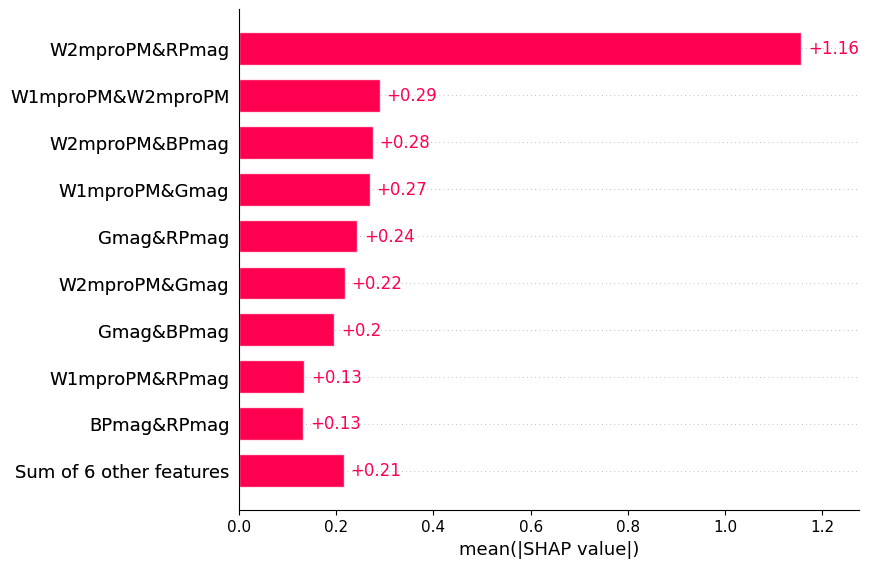

In [12]:
from data_process import get_features
import time
#normalize data

#X,y = shap.datasets.adult()
X_train_test = data[get_features(config.features["train"],config)]
#print(X_train)
degree = np.sort(np.array([1,2,3,4,5,6]))
def f(x):
    #print(x)
    pred = model.predict(x)
    #rez = np.zeros(len(pred))
    #rez[:] = pred[:,:].dot(degree)
    #print(pred)
    rez = np.zeros((len(pred),1))
    rez[:,0] = np.apply_along_axis(np.argmax,axis=1,arr=pred)
    return rez
'''
#print(f(X_train.iloc[:10]))
#print(X_train.iloc[:10])
'''
#y_train_local = y_train[:,:].dot(degree)
#import xgboost
#clustering = shap.utils.hclust(X_train, y_train_local)
#masker = shap.maskers.Partition(X_train, clustering=clustering)
#explainer = shap.explainers.Exact(f,masker)
#shap_values = explainer(X_train.iloc[:100])
#shap.plots.bar(shap_values)
'''
'''
Test = X_train_test.sample(2000, ignore_index=True)

explainer = shap.explainers.Permutation(f,Test)
#explainer = shap.explainers.Permutation(f,Test)

#X_test = X_test.sample(200, ignore_index=True)
#


shap_values = explainer(Test)

#shap.plots.beeswarm(shap_values)

#explainer = shap.explainers.Exact(f, Test)
#shap_values = explainer(Test)

#print(shap_values)
#print(shap_values[0])

shap.plots.bar(shap_values)

#shap.plots.waterfall(shap_values[0])

#Test

In [27]:
temp = pd.DataFrame(f(Test))
print(temp)
uniq = temp.loc[:,0].unique()
print(uniq)
for i in uniq:
    print(f"{i}---{temp[temp.loc[:,0] == i].shape[0]}")

63/63 [==============================] - 0s 365us/step
        0
0     5.0
1     4.0
2     2.0
3     5.0
4     0.0
...   ...
1995  5.0
1996  0.0
1997  4.0
1998  4.0
1999  0.0

[2000 rows x 1 columns]
[5. 4. 2. 0. 3. 1.]
5.0---442
4.0---565
2.0---53
0.0---660
3.0---193
1.0---87


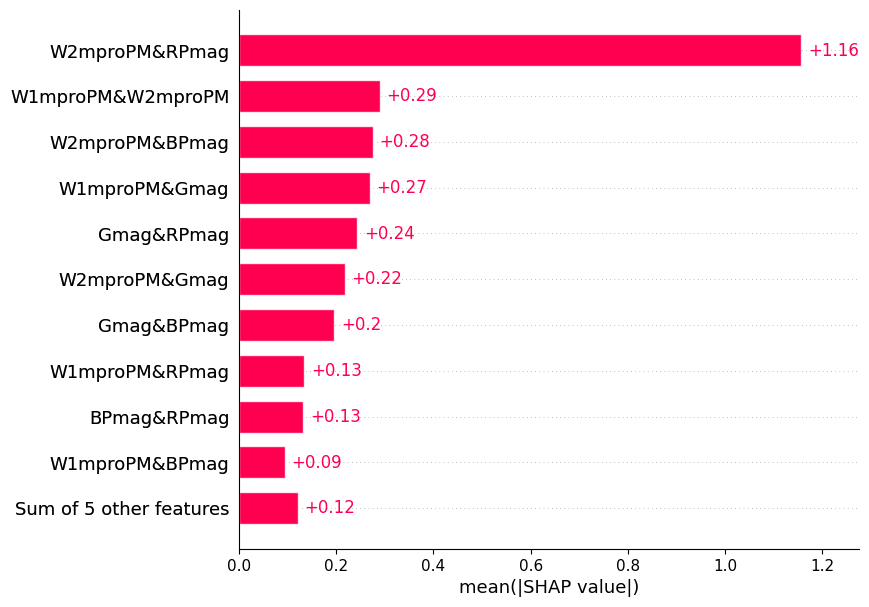

In [32]:
shap.plots.bar(shap_values, max_display=11)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


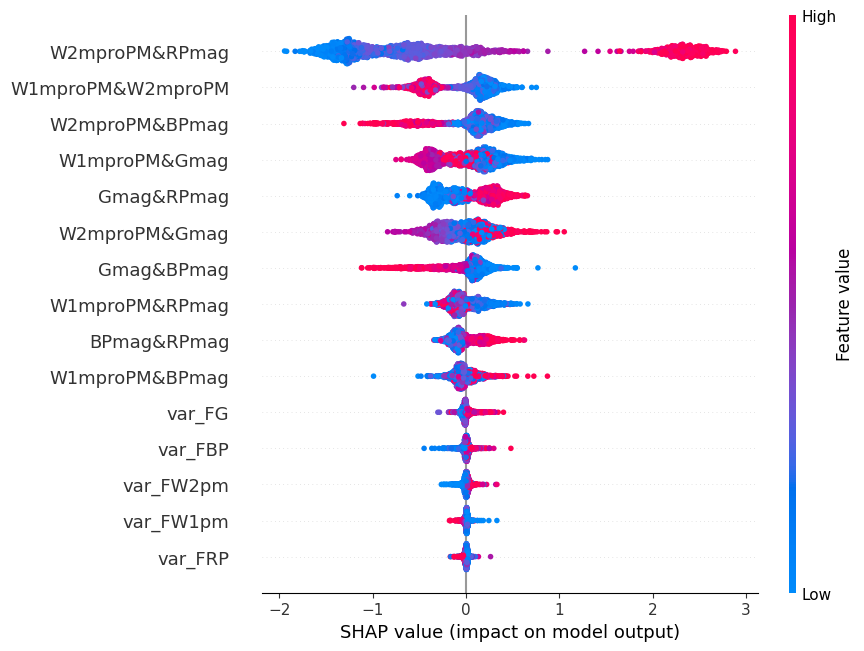

In [29]:
shap.plots.beeswarm(shap_values, max_display=15)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


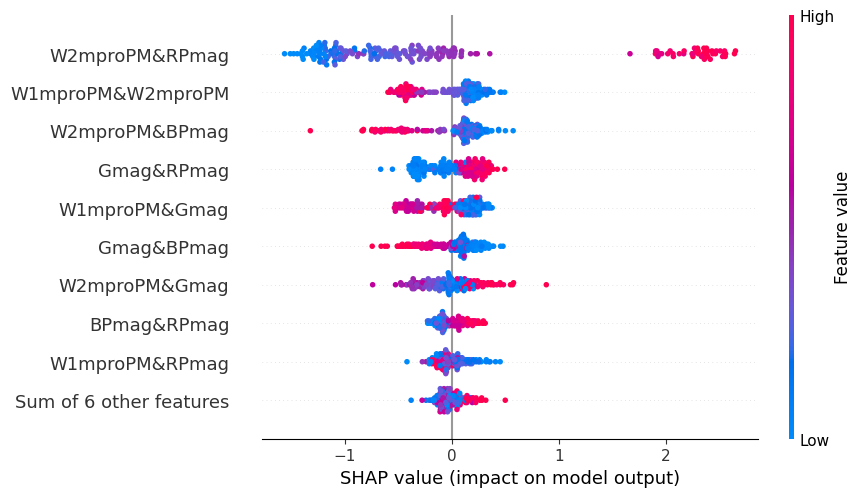

In [18]:
shap.plots.beeswarm(shap_values)

In [32]:
explainer_1 = shap.Explainer(f,Test)

shap_values_1 = explainer_1(Test)

50/50 [==============================] - 0s 492us/step


Permutation explainer:   3%|▎         | 6/200 [00:00<?, ?it/s]

50/50 [==============================] - 0s 488us/step


Permutation explainer:   4%|▍         | 8/200 [00:11<02:53,  1.11it/s]

50/50 [==============================] - 0s 424us/step


Permutation explainer:   4%|▍         | 9/200 [00:13<03:56,  1.24s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:   5%|▌         | 10/200 [00:15<04:27,  1.41s/it]

50/50 [==============================] - 0s 599us/step


Permutation explainer:   6%|▌         | 11/200 [00:16<04:42,  1.49s/it]

50/50 [==============================] - 0s 568us/step


Permutation explainer:   6%|▌         | 12/200 [00:18<04:53,  1.56s/it]

50/50 [==============================] - 0s 650us/step


Permutation explainer:   6%|▋         | 13/200 [00:20<05:00,  1.61s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:   7%|▋         | 14/200 [00:21<05:01,  1.62s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:   8%|▊         | 15/200 [00:23<05:04,  1.64s/it]

50/50 [==============================] - 0s 471us/step


Permutation explainer:   8%|▊         | 16/200 [00:25<05:03,  1.65s/it]

50/50 [==============================] - 0s 467us/step


Permutation explainer:   8%|▊         | 17/200 [00:26<05:02,  1.65s/it]

50/50 [==============================] - 0s 483us/step


Permutation explainer:   9%|▉         | 18/200 [00:28<05:03,  1.67s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  10%|▉         | 19/200 [00:30<05:04,  1.68s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  10%|█         | 20/200 [00:32<05:02,  1.68s/it]

50/50 [==============================] - 0s 546us/step


Permutation explainer:  10%|█         | 21/200 [00:33<05:02,  1.69s/it]

50/50 [==============================] - 0s 470us/step


Permutation explainer:  11%|█         | 22/200 [00:35<05:01,  1.69s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  12%|█▏        | 23/200 [00:37<05:00,  1.70s/it]

50/50 [==============================] - 0s 560us/step


Permutation explainer:  12%|█▏        | 24/200 [00:38<05:01,  1.71s/it]

50/50 [==============================] - 0s 564us/step


Permutation explainer:  12%|█▎        | 25/200 [00:40<04:58,  1.70s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  13%|█▎        | 26/200 [00:42<04:55,  1.70s/it]

50/50 [==============================] - 0s 536us/step


Permutation explainer:  14%|█▎        | 27/200 [00:43<04:53,  1.69s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  14%|█▍        | 28/200 [00:45<04:47,  1.67s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  14%|█▍        | 29/200 [00:47<04:48,  1.69s/it]

50/50 [==============================] - 0s 509us/step


Permutation explainer:  15%|█▌        | 30/200 [00:49<04:47,  1.69s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:  16%|█▌        | 31/200 [00:50<04:46,  1.70s/it]

50/50 [==============================] - 0s 496us/step


Permutation explainer:  16%|█▌        | 32/200 [00:52<04:42,  1.68s/it]

50/50 [==============================] - 0s 559us/step


Permutation explainer:  16%|█▋        | 33/200 [00:54<04:39,  1.67s/it]

50/50 [==============================] - 0s 600us/step


Permutation explainer:  17%|█▋        | 34/200 [00:55<04:36,  1.67s/it]

50/50 [==============================] - 0s 490us/step


Permutation explainer:  18%|█▊        | 35/200 [00:57<04:34,  1.66s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  18%|█▊        | 36/200 [00:59<04:33,  1.67s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  18%|█▊        | 37/200 [01:00<04:30,  1.66s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  19%|█▉        | 38/200 [01:02<04:33,  1.69s/it]

50/50 [==============================] - 0s 509us/step


Permutation explainer:  20%|█▉        | 39/200 [01:04<04:29,  1.67s/it]

50/50 [==============================] - 0s 571us/step


Permutation explainer:  20%|██        | 40/200 [01:05<04:31,  1.70s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  20%|██        | 41/200 [01:07<04:34,  1.73s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  21%|██        | 42/200 [01:09<04:39,  1.77s/it]

50/50 [==============================] - 0s 474us/step


Permutation explainer:  22%|██▏       | 43/200 [01:11<04:36,  1.76s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  22%|██▏       | 44/200 [01:12<04:27,  1.72s/it]

50/50 [==============================] - 0s 476us/step


Permutation explainer:  22%|██▎       | 45/200 [01:14<04:25,  1.71s/it]

50/50 [==============================] - 0s 453us/step


Permutation explainer:  23%|██▎       | 46/200 [01:16<04:19,  1.69s/it]

50/50 [==============================] - 0s 437us/step


Permutation explainer:  24%|██▎       | 47/200 [01:17<04:22,  1.72s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  24%|██▍       | 48/200 [01:19<04:20,  1.71s/it]

50/50 [==============================] - 0s 578us/step


Permutation explainer:  24%|██▍       | 49/200 [01:21<04:18,  1.71s/it]

50/50 [==============================] - 0s 602us/step


Permutation explainer:  25%|██▌       | 50/200 [01:23<04:17,  1.72s/it]

50/50 [==============================] - 0s 491us/step


Permutation explainer:  26%|██▌       | 51/200 [01:24<04:14,  1.71s/it]

50/50 [==============================] - 0s 525us/step


Permutation explainer:  26%|██▌       | 52/200 [01:26<04:11,  1.70s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  26%|██▋       | 53/200 [01:28<04:20,  1.77s/it]

50/50 [==============================] - 0s 486us/step


Permutation explainer:  27%|██▋       | 54/200 [01:30<04:19,  1.78s/it]

50/50 [==============================] - 0s 534us/step


Permutation explainer:  28%|██▊       | 55/200 [01:31<04:16,  1.77s/it]

50/50 [==============================] - 0s 512us/step


Permutation explainer:  28%|██▊       | 56/200 [01:33<04:13,  1.76s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  28%|██▊       | 57/200 [01:35<04:10,  1.75s/it]

50/50 [==============================] - 0s 433us/step


Permutation explainer:  29%|██▉       | 58/200 [01:37<04:09,  1.75s/it]

50/50 [==============================] - 0s 586us/step


Permutation explainer:  30%|██▉       | 59/200 [01:38<04:06,  1.75s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  30%|███       | 60/200 [01:40<04:03,  1.74s/it]

50/50 [==============================] - 0s 455us/step


Permutation explainer:  30%|███       | 61/200 [01:42<04:01,  1.74s/it]

50/50 [==============================] - 0s 519us/step


Permutation explainer:  31%|███       | 62/200 [01:44<03:58,  1.73s/it]

50/50 [==============================] - 0s 419us/step


Permutation explainer:  32%|███▏      | 63/200 [01:45<03:54,  1.72s/it]

50/50 [==============================] - 0s 520us/step


Permutation explainer:  32%|███▏      | 64/200 [01:47<03:53,  1.72s/it]

50/50 [==============================] - 0s 506us/step


Permutation explainer:  32%|███▎      | 65/200 [01:49<03:52,  1.72s/it]

50/50 [==============================] - 0s 539us/step


Permutation explainer:  33%|███▎      | 66/200 [01:50<03:50,  1.72s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  34%|███▎      | 67/200 [01:52<03:47,  1.71s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  34%|███▍      | 68/200 [01:54<03:45,  1.71s/it]

50/50 [==============================] - 0s 513us/step


Permutation explainer:  34%|███▍      | 69/200 [01:56<03:44,  1.71s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  35%|███▌      | 70/200 [01:57<03:42,  1.71s/it]

50/50 [==============================] - 0s 603us/step


Permutation explainer:  36%|███▌      | 71/200 [01:59<03:41,  1.71s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  36%|███▌      | 72/200 [02:01<03:40,  1.72s/it]

50/50 [==============================] - 0s 469us/step


Permutation explainer:  36%|███▋      | 73/200 [02:02<03:39,  1.72s/it]

50/50 [==============================] - 0s 543us/step


Permutation explainer:  37%|███▋      | 74/200 [02:04<03:37,  1.73s/it]

50/50 [==============================] - 0s 521us/step


Permutation explainer:  38%|███▊      | 75/200 [02:06<03:36,  1.73s/it]

50/50 [==============================] - 0s 453us/step


Permutation explainer:  38%|███▊      | 76/200 [02:08<03:33,  1.72s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  38%|███▊      | 77/200 [02:09<03:28,  1.70s/it]

50/50 [==============================] - 0s 560us/step


Permutation explainer:  39%|███▉      | 78/200 [02:11<03:26,  1.69s/it]

50/50 [==============================] - 0s 622us/step


Permutation explainer:  40%|███▉      | 79/200 [02:13<03:25,  1.70s/it]

50/50 [==============================] - 0s 610us/step


Permutation explainer:  40%|████      | 80/200 [02:14<03:23,  1.70s/it]

50/50 [==============================] - 0s 658us/step


Permutation explainer:  40%|████      | 81/200 [02:16<03:21,  1.69s/it]

50/50 [==============================] - 0s 406us/step


Permutation explainer:  41%|████      | 82/200 [02:18<03:18,  1.68s/it]

50/50 [==============================] - 0s 488us/step


Permutation explainer:  42%|████▏     | 83/200 [02:19<03:15,  1.67s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  42%|████▏     | 84/200 [02:21<03:14,  1.68s/it]

50/50 [==============================] - 0s 567us/step


Permutation explainer:  42%|████▎     | 85/200 [02:23<03:10,  1.66s/it]

50/50 [==============================] - 0s 529us/step


Permutation explainer:  43%|████▎     | 86/200 [02:24<03:12,  1.69s/it]

50/50 [==============================] - 0s 550us/step


Permutation explainer:  44%|████▎     | 87/200 [02:26<03:12,  1.70s/it]

50/50 [==============================] - 0s 579us/step


Permutation explainer:  44%|████▍     | 88/200 [02:28<03:12,  1.72s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  44%|████▍     | 89/200 [02:30<03:09,  1.70s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  45%|████▌     | 90/200 [02:31<03:07,  1.71s/it]

50/50 [==============================] - 0s 432us/step


Permutation explainer:  46%|████▌     | 91/200 [02:33<03:05,  1.70s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  46%|████▌     | 92/200 [02:35<03:04,  1.71s/it]

50/50 [==============================] - 0s 636us/step


Permutation explainer:  46%|████▋     | 93/200 [02:36<03:05,  1.73s/it]

50/50 [==============================] - 0s 586us/step


Permutation explainer:  47%|████▋     | 94/200 [02:38<03:03,  1.73s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  48%|████▊     | 95/200 [02:40<03:02,  1.74s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  48%|████▊     | 96/200 [02:42<03:00,  1.73s/it]

50/50 [==============================] - 0s 620us/step


Permutation explainer:  48%|████▊     | 97/200 [02:43<02:56,  1.72s/it]

50/50 [==============================] - 0s 405us/step


Permutation explainer:  49%|████▉     | 98/200 [02:45<02:53,  1.70s/it]

50/50 [==============================] - 0s 464us/step


Permutation explainer:  50%|████▉     | 99/200 [02:47<02:51,  1.69s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  50%|█████     | 100/200 [02:48<02:47,  1.68s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  50%|█████     | 101/200 [02:50<02:45,  1.67s/it]

50/50 [==============================] - 0s 661us/step


Permutation explainer:  51%|█████     | 102/200 [02:52<02:43,  1.67s/it]

50/50 [==============================] - 0s 482us/step


Permutation explainer:  52%|█████▏    | 103/200 [02:53<02:41,  1.66s/it]

50/50 [==============================] - 0s 523us/step


Permutation explainer:  52%|█████▏    | 104/200 [02:55<02:39,  1.66s/it]

50/50 [==============================] - 0s 482us/step


Permutation explainer:  52%|█████▎    | 105/200 [02:57<02:39,  1.68s/it]

50/50 [==============================] - 0s 503us/step


Permutation explainer:  53%|█████▎    | 106/200 [02:58<02:38,  1.69s/it]

50/50 [==============================] - 0s 543us/step


Permutation explainer:  54%|█████▎    | 107/200 [03:00<02:35,  1.67s/it]

50/50 [==============================] - 0s 571us/step


Permutation explainer:  54%|█████▍    | 108/200 [03:02<02:33,  1.67s/it]

50/50 [==============================] - 0s 491us/step


Permutation explainer:  55%|█████▍    | 109/200 [03:03<02:32,  1.67s/it]

50/50 [==============================] - 0s 451us/step


Permutation explainer:  55%|█████▌    | 110/200 [03:05<02:30,  1.67s/it]

50/50 [==============================] - 0s 498us/step


Permutation explainer:  56%|█████▌    | 111/200 [03:07<02:30,  1.69s/it]

50/50 [==============================] - 0s 486us/step


Permutation explainer:  56%|█████▌    | 112/200 [03:08<02:28,  1.69s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  56%|█████▋    | 113/200 [03:10<02:33,  1.77s/it]

50/50 [==============================] - 0s 460us/step


Permutation explainer:  57%|█████▋    | 114/200 [03:12<02:31,  1.77s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  57%|█████▊    | 115/200 [03:14<02:28,  1.75s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  58%|█████▊    | 116/200 [03:16<02:25,  1.73s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  58%|█████▊    | 117/200 [03:17<02:21,  1.70s/it]

50/50 [==============================] - 0s 517us/step


Permutation explainer:  59%|█████▉    | 118/200 [03:19<02:19,  1.70s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  60%|█████▉    | 119/200 [03:21<02:16,  1.68s/it]

50/50 [==============================] - 0s 422us/step


Permutation explainer:  60%|██████    | 120/200 [03:22<02:12,  1.66s/it]

50/50 [==============================] - 0s 514us/step


Permutation explainer:  60%|██████    | 121/200 [03:24<02:10,  1.65s/it]

50/50 [==============================] - 0s 518us/step


Permutation explainer:  61%|██████    | 122/200 [03:26<02:10,  1.67s/it]

50/50 [==============================] - 0s 548us/step


Permutation explainer:  62%|██████▏   | 123/200 [03:27<02:08,  1.66s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  62%|██████▏   | 124/200 [03:29<02:04,  1.64s/it]

50/50 [==============================] - 0s 429us/step


Permutation explainer:  62%|██████▎   | 125/200 [03:30<02:05,  1.67s/it]

50/50 [==============================] - 0s 617us/step


Permutation explainer:  63%|██████▎   | 126/200 [03:32<02:04,  1.68s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:  64%|██████▎   | 127/200 [03:34<02:03,  1.69s/it]

50/50 [==============================] - 0s 512us/step


Permutation explainer:  64%|██████▍   | 128/200 [03:36<02:00,  1.68s/it]

50/50 [==============================] - 0s 487us/step


Permutation explainer:  64%|██████▍   | 129/200 [03:37<01:59,  1.68s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:  65%|██████▌   | 130/200 [03:39<01:58,  1.69s/it]

50/50 [==============================] - 0s 483us/step


Permutation explainer:  66%|██████▌   | 131/200 [03:41<01:56,  1.69s/it]

50/50 [==============================] - 0s 507us/step


Permutation explainer:  66%|██████▌   | 132/200 [03:42<01:54,  1.69s/it]

50/50 [==============================] - 0s 636us/step


Permutation explainer:  66%|██████▋   | 133/200 [03:44<01:52,  1.68s/it]

50/50 [==============================] - 0s 517us/step


Permutation explainer:  67%|██████▋   | 134/200 [03:46<01:50,  1.67s/it]

50/50 [==============================] - 0s 624us/step


Permutation explainer:  68%|██████▊   | 135/200 [03:47<01:49,  1.68s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:  68%|██████▊   | 136/200 [03:49<01:47,  1.67s/it]

50/50 [==============================] - 0s 762us/step


Permutation explainer:  68%|██████▊   | 137/200 [03:51<01:45,  1.68s/it]

50/50 [==============================] - 0s 461us/step


Permutation explainer:  69%|██████▉   | 138/200 [03:52<01:44,  1.69s/it]

50/50 [==============================] - 0s 566us/step


Permutation explainer:  70%|██████▉   | 139/200 [03:54<01:42,  1.68s/it]

50/50 [==============================] - 0s 513us/step


Permutation explainer:  70%|███████   | 140/200 [03:56<01:41,  1.69s/it]

50/50 [==============================] - 0s 485us/step


Permutation explainer:  70%|███████   | 141/200 [03:57<01:40,  1.70s/it]

50/50 [==============================] - 0s 548us/step


Permutation explainer:  71%|███████   | 142/200 [03:59<01:39,  1.71s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  72%|███████▏  | 143/200 [04:01<01:37,  1.71s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  72%|███████▏  | 144/200 [04:03<01:35,  1.71s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  72%|███████▎  | 145/200 [04:04<01:32,  1.68s/it]

50/50 [==============================] - 0s 587us/step


Permutation explainer:  73%|███████▎  | 146/200 [04:06<01:31,  1.69s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  74%|███████▎  | 147/200 [04:08<01:29,  1.69s/it]

50/50 [==============================] - 0s 492us/step


Permutation explainer:  74%|███████▍  | 148/200 [04:09<01:27,  1.69s/it]

50/50 [==============================] - 0s 582us/step


Permutation explainer:  74%|███████▍  | 149/200 [04:11<01:26,  1.69s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  75%|███████▌  | 150/200 [04:13<01:24,  1.69s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  76%|███████▌  | 151/200 [04:14<01:23,  1.71s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  76%|███████▌  | 152/200 [04:16<01:21,  1.70s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  76%|███████▋  | 153/200 [04:18<01:20,  1.70s/it]

50/50 [==============================] - 0s 650us/step


Permutation explainer:  77%|███████▋  | 154/200 [04:20<01:17,  1.69s/it]

50/50 [==============================] - 0s 459us/step


Permutation explainer:  78%|███████▊  | 155/200 [04:21<01:15,  1.68s/it]

50/50 [==============================] - 0s 417us/step


Permutation explainer:  78%|███████▊  | 156/200 [04:23<01:13,  1.67s/it]

50/50 [==============================] - 0s 490us/step


Permutation explainer:  78%|███████▊  | 157/200 [04:24<01:11,  1.66s/it]

50/50 [==============================] - 0s 468us/step


Permutation explainer:  79%|███████▉  | 158/200 [04:26<01:09,  1.65s/it]

50/50 [==============================] - 0s 499us/step


Permutation explainer:  80%|███████▉  | 159/200 [04:28<01:07,  1.65s/it]

50/50 [==============================] - 0s 466us/step


Permutation explainer:  80%|████████  | 160/200 [04:29<01:05,  1.63s/it]

50/50 [==============================] - 0s 465us/step


Permutation explainer:  80%|████████  | 161/200 [04:31<01:03,  1.63s/it]

50/50 [==============================] - 0s 473us/step


Permutation explainer:  81%|████████  | 162/200 [04:33<01:02,  1.64s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  82%|████████▏ | 163/200 [04:34<01:00,  1.65s/it]

50/50 [==============================] - 0s 523us/step


Permutation explainer:  82%|████████▏ | 164/200 [04:36<00:59,  1.64s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  82%|████████▎ | 165/200 [04:38<00:58,  1.66s/it]

50/50 [==============================] - 0s 506us/step


Permutation explainer:  83%|████████▎ | 166/200 [04:39<00:57,  1.68s/it]

50/50 [==============================] - 0s 508us/step


Permutation explainer:  84%|████████▎ | 167/200 [04:41<00:55,  1.68s/it]

50/50 [==============================] - 0s 468us/step


Permutation explainer:  84%|████████▍ | 168/200 [04:43<00:53,  1.67s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  84%|████████▍ | 169/200 [04:44<00:52,  1.68s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  85%|████████▌ | 170/200 [04:46<00:50,  1.67s/it]

50/50 [==============================] - 0s 494us/step


Permutation explainer:  86%|████████▌ | 171/200 [04:48<00:48,  1.66s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  86%|████████▌ | 172/200 [04:49<00:46,  1.67s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  86%|████████▋ | 173/200 [04:51<00:44,  1.66s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  87%|████████▋ | 174/200 [04:53<00:45,  1.74s/it]

50/50 [==============================] - 0s 507us/step


Permutation explainer:  88%|████████▊ | 175/200 [04:55<00:43,  1.76s/it]

50/50 [==============================] - 0s 591us/step


Permutation explainer:  88%|████████▊ | 176/200 [04:57<00:42,  1.76s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  88%|████████▊ | 177/200 [04:58<00:40,  1.75s/it]

50/50 [==============================] - 0s 534us/step


Permutation explainer:  89%|████████▉ | 178/200 [05:00<00:38,  1.74s/it]

50/50 [==============================] - 0s 487us/step


Permutation explainer:  90%|████████▉ | 179/200 [05:02<00:36,  1.73s/it]

50/50 [==============================] - 0s 438us/step


Permutation explainer:  90%|█████████ | 180/200 [05:03<00:34,  1.70s/it]

50/50 [==============================] - 0s 488us/step


Permutation explainer:  90%|█████████ | 181/200 [05:05<00:32,  1.70s/it]

50/50 [==============================] - 0s 441us/step


Permutation explainer:  91%|█████████ | 182/200 [05:07<00:30,  1.69s/it]

50/50 [==============================] - 0s 464us/step


Permutation explainer:  92%|█████████▏| 183/200 [05:08<00:28,  1.69s/it]

50/50 [==============================] - 0s 492us/step


Permutation explainer:  92%|█████████▏| 184/200 [05:10<00:27,  1.69s/it]

50/50 [==============================] - 0s 580us/step


Permutation explainer:  92%|█████████▎| 185/200 [05:12<00:25,  1.68s/it]

50/50 [==============================] - 0s 426us/step


Permutation explainer:  93%|█████████▎| 186/200 [05:13<00:23,  1.69s/it]

50/50 [==============================] - 0s 573us/step


Permutation explainer:  94%|█████████▎| 187/200 [05:15<00:21,  1.68s/it]

50/50 [==============================] - 0s 484us/step


Permutation explainer:  94%|█████████▍| 188/200 [05:17<00:20,  1.68s/it]

50/50 [==============================] - 0s 341us/step


Permutation explainer:  94%|█████████▍| 189/200 [05:18<00:18,  1.68s/it]

50/50 [==============================] - 0s 503us/step


Permutation explainer:  95%|█████████▌| 190/200 [05:20<00:16,  1.69s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  96%|█████████▌| 191/200 [05:22<00:15,  1.69s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  96%|█████████▌| 192/200 [05:24<00:13,  1.68s/it]

50/50 [==============================] - 0s 489us/step


Permutation explainer:  96%|█████████▋| 193/200 [05:25<00:11,  1.69s/it]

50/50 [==============================] - 0s 473us/step


Permutation explainer:  97%|█████████▋| 194/200 [05:27<00:10,  1.68s/it]

50/50 [==============================] - 0s 568us/step


Permutation explainer:  98%|█████████▊| 195/200 [05:29<00:08,  1.68s/it]

50/50 [==============================] - 0s 481us/step


Permutation explainer:  98%|█████████▊| 196/200 [05:30<00:06,  1.66s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  98%|█████████▊| 197/200 [05:32<00:05,  1.67s/it]

50/50 [==============================] - 0s 540us/step


Permutation explainer:  99%|█████████▉| 198/200 [05:33<00:03,  1.66s/it]

50/50 [==============================] - 0s 472us/step


Permutation explainer: 100%|█████████▉| 199/200 [05:35<00:01,  1.65s/it]

50/50 [==============================] - 0s 459us/step


Permutation explainer: 100%|██████████| 200/200 [05:37<00:00,  1.65s/it]

50/50 [==============================] - 0s 520us/step


Permutation explainer: 201it [05:38,  1.74s/it]                         


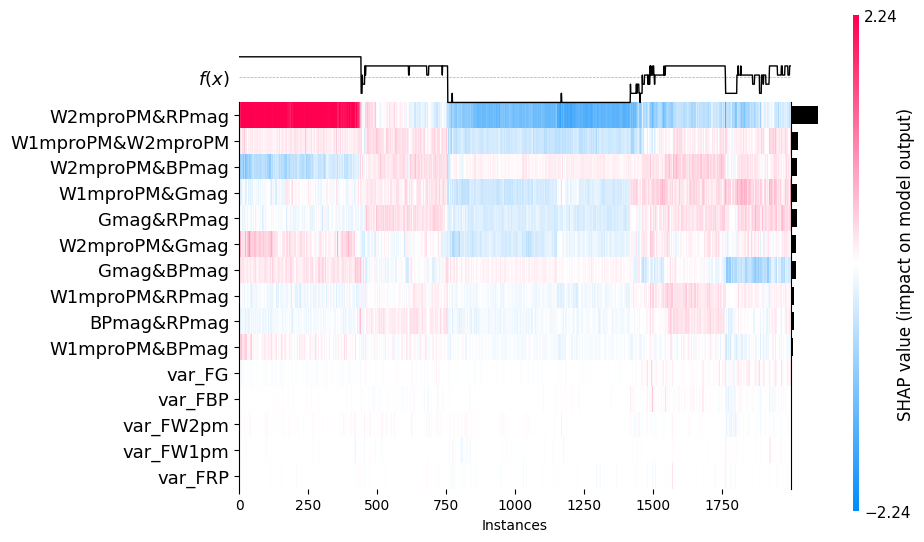

In [30]:
shap.plots.heatmap(shap_values, max_display=15)

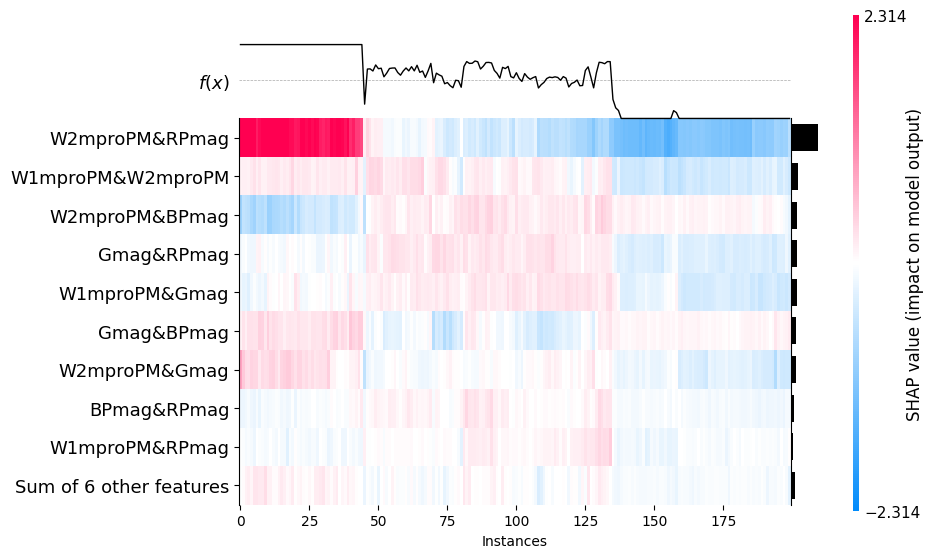

In [38]:
shap.plots.heatmap(shap_values_1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


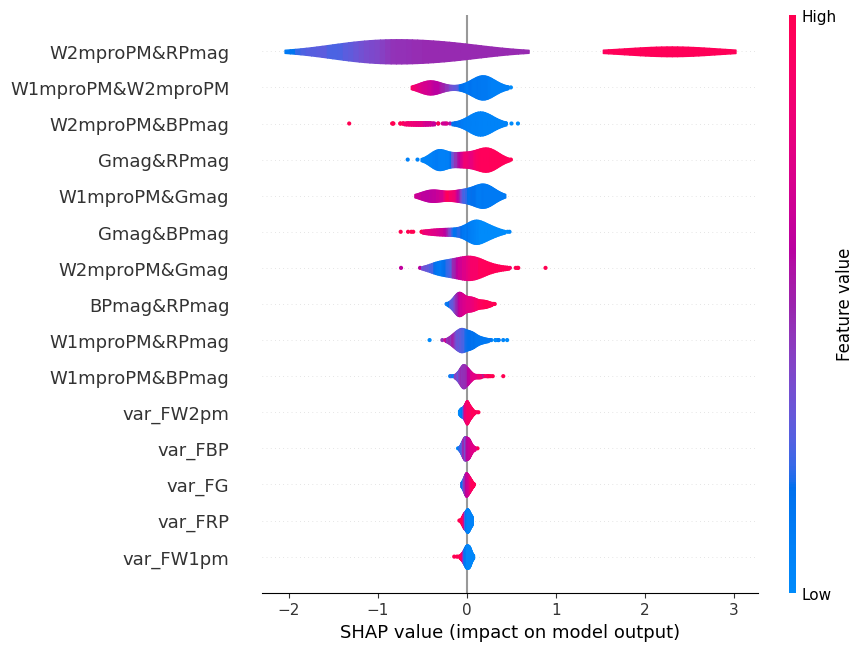

In [66]:
shap.plots.violin(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


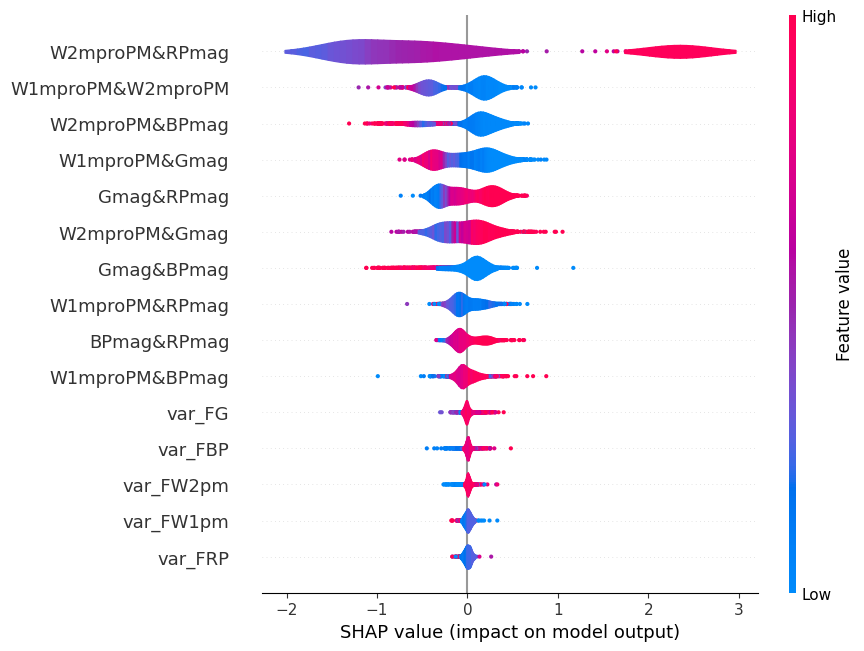

In [33]:
shap.plots.violin(shap_values)

In [28]:
shap_values[0]

.values =
array([ 0.00173889, -0.00346759, -0.01073736,  0.02292066, -0.00142215,
        0.2298579 ,  0.26248422,  0.04673874,  0.06033033, -0.02283812,
        0.24109178, -0.53074855, -0.14562305,  0.09562395, -0.02954917])

.base_values =
array([3.61395549])

.data =
array([ 0.0570879 ,  0.08168827,  0.19436402,  0.34222335,  0.29455799,
        0.07221206, -5.90738542, -4.52758142, -3.31184894, -5.97959748,
       -4.59979348, -3.384061  ,  1.37980401,  2.59553649,  1.21573248])

In [24]:
shap_values[0, :]

.values =
array([ 0.00173889, -0.00346759, -0.01073736,  0.02292066, -0.00142215,
        0.2298579 ,  0.26248422,  0.04673874,  0.06033033, -0.02283812,
        0.24109178, -0.53074855, -0.14562305,  0.09562395, -0.02954917])

.base_values =
array([3.61395549])

.data =
array([ 0.0570879 ,  0.08168827,  0.19436402,  0.34222335,  0.29455799,
        0.07221206, -5.90738542, -4.52758142, -3.31184894, -5.97959748,
       -4.59979348, -3.384061  ,  1.37980401,  2.59553649,  1.21573248])

In [13]:
shap_values

.values =
array([[ 0.00173889, -0.00346759, -0.01073736, ..., -0.14562305,
         0.09562395, -0.02954917],
       [ 0.00755325, -0.03882675,  0.02552895, ..., -0.1595758 ,
         0.0415589 ,  0.0578264 ],
       [-0.0359397 ,  0.13105443, -0.01763806, ...,  0.28326654,
        -0.1370922 , -0.19416574],
       ...,
       [ 0.00130436, -0.00052673, -0.00663397, ...,  0.06565334,
        -0.35912087, -0.08535226],
       [-0.00311409, -0.01404963,  0.01009396, ..., -0.01501787,
         0.26860541,  0.14209418],
       [ 0.00231772, -0.00419099,  0.00954778, ..., -0.19616987,
         0.20744554,  0.09300207]])

.base_values =
array([[3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
    

In [36]:
from joblib import dump,load

dump(shap_values,f"{config.path_stat}/{config.name_sample}_shap.csv")



['/home/lrikozavr/ML_work/agn_sdss/statistic/sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e20_v02_arelu_erecall_ldropout_var_color_shap.csv']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


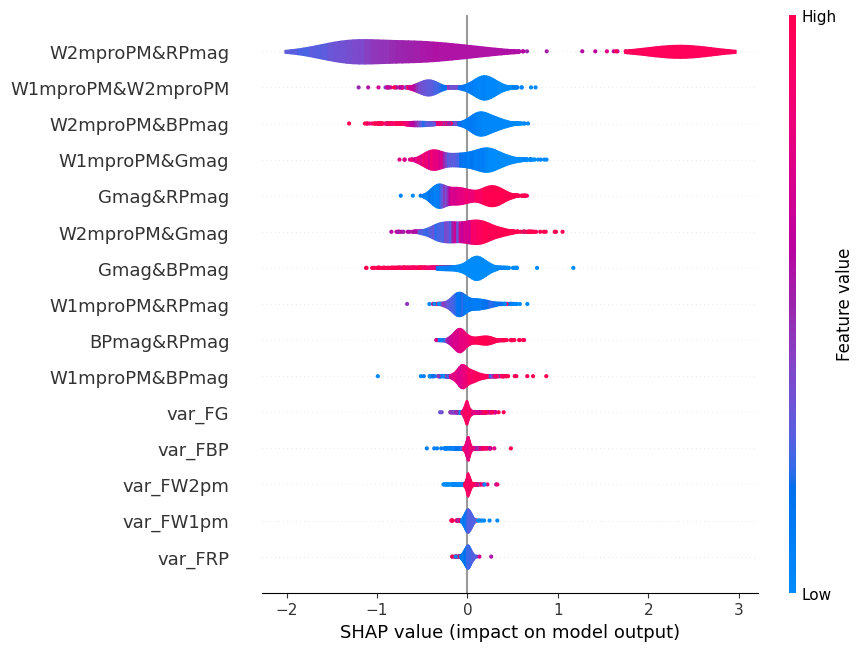

In [37]:
sh = load(f"{config.path_stat}/{config.name_sample}_shap.csv")

shap.plots.violin(sh)